In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/My\ Drive/Colab\ Notebooks/meme-evolution-main/

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/meme-evolution-main


In [4]:
import pandas as pd
import numpy as np

In [ ]:
!pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --index-url https://download.pytorch.org/whl/cu121
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html

In [ ]:
!pip install torchutils
!pip install datasets
!pip install umap-learn

In [ ]:
!pip install adjustText

In [ ]:
import dgl

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


## Data 3.5 4chan

In [16]:
import pandas as pd
import json

# Initialize an empty list to store processed data
data = []

# Read and filter the data
with open('rewire.txt', 'r') as file:
    for line in file:
        entry = json.loads(line.strip())  # Load each line as a JSON object
        if entry["confidence_score"] > 0.8:  # Filter by confidence score
            # Transform labels: "non-hateful" to 1, "hateful" to 0
            entry["label"] = 1 if entry["label"] == "non-hateful" else 0
            data.append(entry)

# Create the DataFrame
chan = pd.DataFrame(data)

# Select only the required columns
chan = chan[['label', 'confidence_score', 'text', 'request_time', 'line_idx']]

## The slur expert

In [ ]:
slur_expert = pd.read_csv("kurrek.2020.slur-corpus.csv")
slur_expert.drop(['subreddit', 'author'], axis=1, inplace=True)
slur_expert = slur_expert.dropna(subset=['gold_label'])

In [ ]:
slur_expert = slur_expert[slur_expert['gold_label'] != 'CMP']

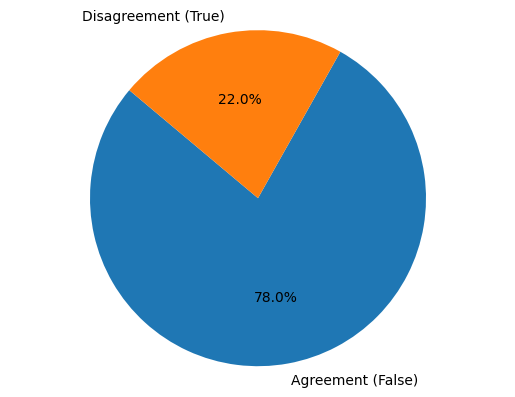

In [ ]:
import matplotlib.pyplot as plt

true_count = len(slur_expert[slur_expert['disagreement'] == True])

total_entries = len(slur_expert)
true_proportion = true_count / total_entries

false_proportion = 1 - true_proportion

labels = ['Agreement (False)', 'Disagreement (True)']
sizes = [false_proportion, true_proportion]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

plt.axis('equal')
plt.show()

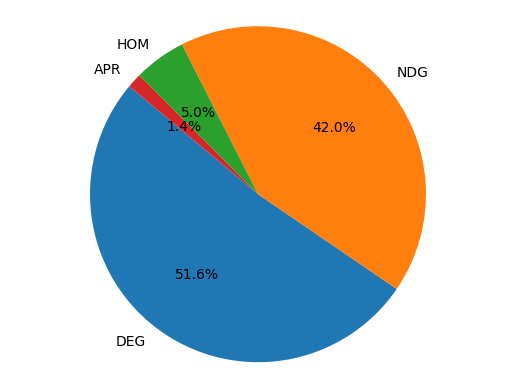

In [ ]:
# Calculate the value counts for the 'gold_label' column
value_counts = slur_expert['gold_label'].value_counts()
labels = value_counts.index.tolist()
sizes = value_counts.values.tolist()

# Create a pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.show()

In [ ]:
## For the purposes of this task, the labels are hate speech (Derogratory) x normal (Non Derogatory Non Appropriative, Homonym, Appropriative)

label_mapping = {'DEG': 0, 'NDG': 1, 'HOM': 1, 'APR': 1}
slur_expert['gold_label'] = slur_expert['gold_label'].replace(label_mapping).astype(int)

<ipython-input-12-8e125e821c9f>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  slur_expert['gold_label'] = slur_expert['gold_label'].replace(label_mapping).astype(int)


In [ ]:
agreed_slur_expert = slur_expert[slur_expert['disagreement'] == False].copy()

In [ ]:
# Function to create synthetic posts
def create_synthetic_posts(df):
    slur_to_post_id = {}
    synthetic_posts = []

    for i, row in df.iterrows():
        slur = row['slur']

        # Check if the synthetic post for this slur already exists
        if slur in slur_to_post_id:
            synthetic_post_id = slur_to_post_id[slur]
        else:
            # Create a new synthetic post ID
            synthetic_post_id = f'synthetic_{slur}'
            slur_to_post_id[slur] = synthetic_post_id

            # Create the synthetic post
            synthetic_post = {
                'id': synthetic_post_id,
                'link_id': row['link_id'],
                'parent_id': '',  # Synthetic post, so no parent
                'score': 0,  # Assuming synthetic posts have a score of 0
                'slur': slur,
                'body': slur,
                'disagreement': False,
                'gold_label': 1
            }
            synthetic_posts.append(synthetic_post)

        # Update the parent_id of the comment to the synthetic post ID
        df.at[i, 'parent_id'] = synthetic_post_id

    # Create a DataFrame for synthetic posts and concatenate with the original DataFrame
    synthetic_df = pd.DataFrame(synthetic_posts)
    return pd.concat([df, synthetic_df], ignore_index=True)

# Create synthetic posts and update the DataFrame
agreed_df = create_synthetic_posts(agreed_slur_expert)
agreed_df.head()

,id,link_id,parent_id,score,slur,body,disagreement,gold_label
0,t1_c3s59yl,t3_pta2s,synthetic_tranny,10.0,tranny,Fuck that I dont wanna watch tranny porn.,False,0
1,t1_e5li3m3,t3_9e0lfg,synthetic_tranny,34.0,tranny,Opie just wanted to have a good time. The same...,False,0
2,t1_e5tpq0a,t3_9f3ytm,synthetic_faggot,61.0,faggot,Fuck that faggot Fallon. Fucking sissy boy act...,False,0
3,t1_c93xbko,t3_1b5k0c,synthetic_faggot,605.0,faggot,BbBB...b.b..b.bb but OP's a faggot,False,0
4,t1_e1wwfj1,t3_8wj0bg,synthetic_tranny,8.0,tranny,Who even uses the word tranny except for trans...,False,1


In [ ]:
agreed_df.parent_id.unique()

array(['synthetic_tranny', 'synthetic_faggot', 'synthetic_nigger', ''],
      dtype=object)

In [ ]:
test_df = agreed_df.sample(n=1000).reset_index()
test_df = create_synthetic_posts(test_df)

test_df = test_df[['body','gold_label']]
test_df.head()

,body,gold_label
0,Neck yourself faggot,0
1,"yes, because whenever someone refers to ""concr...",1
2,The Democrats are masters at taking an issue t...,0
3,People who say this kind of crap aren't much f...,1
4,Pictures?! Ha!!! I have far more than pictures...,1


In [ ]:
# Get data

slur_df = agreed_slur_expert[['body','gold_label']]

In [ ]:
from sklearn.model_selection import train_test_split

trainDF, testDF = train_test_split(slur_df, test_size=0.2, random_state=42)

# Reset the indices of train_df and test_df
trainDF.reset_index(drop=True, inplace=True)
testDF.reset_index(drop=True, inplace=True)

print("Training dataset shape:", trainDF.shape)
print("Testing dataset shape:", testDF.shape)

print(trainDF.head())

Training dataset shape: (24826, 2)
Testing dataset shape: (6207, 2)
                                                body  gold_label
0  &gt; yeah i think it's just about time to wrap...           1
1  ofc, I think thats kinda the natural way, My d...           0
2  Great, then a new word will come up. It still ...           1
3  By that logic, it's perfectly alright to call ...           1
4  I have no problemm with the transgenderes they...           0


In [ ]:
x_train = trainDF['body'].tolist()
y_train = trainDF['gold_label'].tolist()

x_test = testDF['body'].tolist()
y_test = testDF['gold_label'].tolist()

In [ ]:
trainDF, testDF = train_test_split(test_df, test_size=0.2, random_state=42)

train_x = trainDF['body'].tolist()
train_y = trainDF['gold_label'].tolist()

test_x = testDF['body'].tolist()
test_y = testDF['gold_label'].tolist()

## Sarcasm Dataset

In [ ]:
sarcasm_expert = pd.read_csv("train.En.csv")
sarcasm_expert.head()

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
sarcasm_df = pd.DataFrame(columns=["text", "label"])

for index, row in sarcasm_expert.iterrows():

  sarcasm_df = pd.concat([sarcasm_df, pd.DataFrame({"text": [row["tweet"]], "label": [1]})], ignore_index=True)

  # Add rephrased non-sarcastic tweet (label 0) if it exists
  if pd.notnull(row["rephrase"]):
    sarcasm_df = pd.concat([sarcasm_df, pd.DataFrame({"text": [row["rephrase"]], "label": [0]})], ignore_index=True)

# Add non-sarcastic tweets
non_sarcastic_tweets = sarcasm_expert[sarcasm_expert["sarcastic"] == 0]
non_sarcastic_tweets = non_sarcastic_tweets.rename(columns={"tweet": "text", "sarcastic": "label"})
sarcasm_df = pd.concat([sarcasm_df, non_sarcastic_tweets[["text", "label"]]], ignore_index=True)

sarcasm_df["text"] = sarcasm_df["text"].astype(str)
sarcasm_df["label"] = sarcasm_df["label"].astype(int)

# View the first few rows of sarcasm_df
sarcasm_df.head()

,text,label
0,The only thing I got from college is a caffein...,1
1,"College is really difficult, expensive, tiring...",0
2,I love it when professors draw a big question ...,1
3,I do not like when professors don’t write out ...,0
4,Remember the hundred emails from companies whe...,1


## Validation df

In [ ]:
val_df = pd.read_csv("HS expert.csv", header=None)
val_df[0] = val_df[0].astype(str)

In [ ]:
val_df.rename(columns={0: 'text'}, inplace=True)
val_df.rename(columns={1: 'label'}, inplace=True)

## Preprocessing

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
!pip install wordcloud

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk import pos_tag
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import re

tok = WordPunctTokenizer()

def clean_text(text):
  """
  Cleans text by removing HTML tags, numbers, punctuation (except .,!?(), /), and extra spaces.
  Maintains repetition of parentheses.

  Args:
      text (str): The text to be cleaned.

  Returns:
      str: The cleaned text.
  """
  text = re.sub(r'\>>\d+', '', text)
  # Remove HTML tags
  text = re.sub("\'", "", text)
  # Remove numbers
  text = re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", "", text)
  # Remove smart quotes
  text = re.sub("(?<=\w)[‘`’'](?=\w)", '', text)
  # Replace greater than symbol with space
  text = re.sub(r'&gt;', ' ', text)
  # Remove HTML tags again (in case nested)
  text = re.sub(r'<[^>]*>', ' ', text)
  text = re.sub(r'[^\w\s()]|http\S+', '', text)
  # Lowercase text
  text = text.lower()
  # Remove non-alphanumeric characters except for .,!?(), / and keep repeated parenthesis
  text = re.sub(r'[^\w\s\.,!?\\]+|[\(\)]', "", text)
  # Remove extra spaces
  text = re.sub(r'\s+', ' ', text).strip()
  return text

def preprocess_comments(comments):
  # Make all words lowercase (combine steps 1 & 2)
  comments2 = comments.apply(clean_text)

  # Tokenization
  tokenized_comments = []
  for comment in comments2:
      tokenized_comments.append(tok.tokenize(comment))

  # Remove stopwords using set comprehension
  stop_words = set(stopwords.words("english"))
  tokenized_comments2 = [
      [word for word in comment if word.lower() not in stop_words]
      for comment in tokenized_comments
  ]

  # Count the frequency of each word
  word_counts = Counter([word for comment in tokenized_comments2 for word in comment])

  return comments2, tokenized_comments2, word_counts


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [ ]:
#read extracted data
df_posts = agreed_df
df_posts['body'] = df_posts['body'].apply(clean_text)
df_posts.head()

,id,link_id,parent_id,score,slur,body,disagreement,gold_label
0,t1_c3s59yl,t3_pta2s,synthetic_tranny,10.0,tranny,fuck that i dont wanna watch tranny porn,False,0
1,t1_e5li3m3,t3_9e0lfg,synthetic_tranny,34.0,tranny,opie just wanted to have a good time the same ...,False,0
2,t1_e5tpq0a,t3_9f3ytm,synthetic_faggot,61.0,faggot,fuck that faggot fallon fucking sissy boy acti...,False,0
3,t1_c93xbko,t3_1b5k0c,synthetic_faggot,605.0,faggot,bbbbbbbbb but ops a faggot,False,0
4,t1_e1wwfj1,t3_8wj0bg,synthetic_tranny,8.0,tranny,who even uses the word tranny except for trans...,False,1


In [ ]:
len(df_posts)

31036

In [ ]:
# Tokenize the comments
train_comments = df_posts.body.astype(str)
train_comments, train_tc, train_wc = preprocess_comments(train_comments)


In [ ]:
# read extracted data
df_posts2 = chan.copy()
# Remove citations from comments
df_posts2['text'] = df_posts2['text'].apply(clean_text)

train_comments2 = df_posts2.text.astype(str)
train_comments2, train_tc2, train_wc2 = preprocess_comments(df_posts2.text.astype(str))



In [ ]:
# read extracted data
df_posts3 = sarcasm_df.copy()
# Remove citations from comments
df_posts3['text'] = df_posts3['text'].apply(clean_text)

train_comments3 = df_posts3.text.astype(str)
train_comments3, train_tc3, train_wc3 = preprocess_comments(df_posts3.text.astype(str))


In [ ]:
val_df['text'] = val_df['text'].apply(clean_text)

val_com = val_df.text.astype(str)
val_com, val_tc, val_wc = preprocess_comments(val_df.text.astype(str))

## Data preparing

In [ ]:
slur_test = df_posts[21000:22000]
df_posts = df_posts[0:10000]
df_posts3 = df_posts3[0:10000]

In [7]:
import torch
from transformers import BertTokenizer, BertModel, GraphormerConfig, GraphormerForGraphClassification
from nltk.tokenize import sent_tokenize
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split, RandomSampler, SequentialSampler
import torch
from tqdm import tqdm
import gc
import os

# Load tokenizer and model on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
def tokenize_sentences(sentences):
    input_ids = []
    attention_masks = []

    for sentence in sentences:
        encoded_dict = tokenizer.encode_plus(
            sentence,                      # Sentence to encode
            add_special_tokens=True,       # Add '[CLS]' and '[SEP]'
            max_length=128,                # Pad & truncate all sentences
            padding='max_length',
            return_attention_mask=True,    # Construct attention masks
            return_tensors='pt',           # Return pytorch tensors
            truncation=True
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

input_ids, attention_masks = tokenize_sentences(df_posts['body'])
labels = torch.tensor(df_posts['gold_label'].values).to(device)

In [9]:
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_token_embeddings(model, input_ids, attention_masks, batch_size=32):
    model.eval()
    all_embeddings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(input_ids), batch_size), desc="Getting token embeddings"):
            batch_input_ids = input_ids[i:i+batch_size].to(device)  # Move tensors to the device
            batch_attention_masks = attention_masks[i:i+batch_size].to(device)

            outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
            embeddings = outputs.last_hidden_state.cpu()  # Move embeddings back to CPU

            all_embeddings.append(embeddings)

            del batch_input_ids, batch_attention_masks, outputs
            torch.cuda.empty_cache()
            gc.collect()

    return torch.cat(all_embeddings, dim=0)

embeddings = get_token_embeddings(bert_model, input_ids, attention_masks)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [18]:
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
slur_input_ids, slur_attention_masks = tokenize_sentences(slur_test['body'])
slur_labels = torch.tensor(slur_test['gold_label'].values).to(device)
slur_input_ids = slur_input_ids.to(device)
slur_attention_masks = slur_attention_masks.to(device)

slur_embeddings = get_token_embeddings(bert_model, slur_input_ids, slur_attention_masks)

Getting token embeddings: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]


In [17]:
chan_input_ids, chan_attention_masks = tokenize_sentences(df_posts2['text'])
chan_labels = torch.tensor(df_posts2['label'].values).to(device)
chan_input_ids = chan_input_ids.to(device)
chan_attention_masks = chan_attention_masks.to(device)

chan_embeddings = get_token_embeddings(bert_model, chan_input_ids, chan_attention_masks)

Getting token embeddings: 100%|██████████| 26/26 [00:10<00:00,  2.50it/s]


In [ ]:
#for sarcasm

sarc_input_ids, sarc_attention_masks = tokenize_sentences(df_posts3['text'])
sarc_labels = torch.tensor(df_posts3['label'].values).to(device)
sarc_input_ids = sarc_input_ids.to(device)
sarc_attention_masks = sarc_attention_masks.to(device)

text_column = 'text'
label_column = 'label'
sarc_embeddings = get_token_embeddings(bert_model, sarc_input_ids, sarc_attention_masks)

Getting token embeddings: 100%|██████████| 217/217 [01:36<00:00,  2.25it/s]


In [ ]:
val_input_ids, val_attention_masks = tokenize_sentences(val_df["text"])
val_labels = torch.tensor(val_df["label"].values).to(device)
val_input_ids = val_input_ids.to(device)
val_attention_masks = val_attention_masks.to(device)

val_embeddings = get_token_embeddings(bert_model, val_input_ids, val_attention_masks)

Getting token embeddings: 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]


## Graphormer

In [19]:
import dgl

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [20]:
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = labels

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

In [21]:
def normalize_embeddings(embeddings):
    # Min-max normalize the embeddings to the range [0, 1]
    min_val = embeddings.min(dim=-1, keepdim=True)[0]
    max_val = embeddings.max(dim=-1, keepdim=True)[0]
    normalized_embeddings = (embeddings - min_val) / (max_val - min_val + 1e-5)
    return normalized_embeddings

def quantize_embeddings(normalized_embeddings, num_bins=256):
    # Quantize the normalized embeddings to discrete values
    quantized_embeddings = (normalized_embeddings * (num_bins - 1)).long()
    return quantized_embeddings

# Normalize embeddings
normalized_embeddings = normalize_embeddings(embeddings)

# Quantize embeddings
num_bins = 256
quantized_embeddings = quantize_embeddings(normalized_embeddings, num_bins=num_bins)

In [22]:
def create_dgl_graphs(df_posts, input_ids, attention_masks, embeddings_list, text_column='body',
                     label_column='gold_label', num_classes=2):
    """
    Create DGL graphs from text data with configurable column names.

    Returns:
        tuple: (list of DGL graphs, tensor of labels)
    """
    # Load spaCy English model
    nlp = spacy.load("en_core_web_sm")

    graphs = []
    labels = []

    for i in range(len(df_posts)):
        sentence = df_posts[text_column].iloc[i]
        mask = attention_masks[i]
        num_tokens = int(mask.sum())

        # Create graph
        g = dgl.graph(([], []), num_nodes=num_tokens)

        # Add sequential edges
        src = list(range(num_tokens - 1))
        dst = list(range(1, num_tokens))
        g.add_edges(src, dst)
        g.add_edges(dst, src)

        # Perform dependency parsing
        doc = nlp(sentence)

        # Add dependency edges
        for token in doc:
            if token.i < num_tokens and token.head.i < num_tokens:
                g.add_edges(token.i, token.head.i)
                g.add_edges(token.head.i, token.i)

        # Assign node features (use embeddings for valid tokens only)
        node_features = embeddings_list[i].clone().detach()[:num_tokens]
        g.ndata['feat'] = node_features

        # Add edge types
        edge_types = []
        for u, v in zip(g.edges()[0], g.edges()[1]):
            if abs(int(u) - int(v)) == 1:
                edge_types.append(0)  # Sequential edge
            else:
                edge_types.append(1)  # Dependency edge
        g.edata['type'] = torch.tensor(edge_types)

        # Add graph-level attributes
        g.graph_data = {
            'original_text': sentence,
        }

        graphs.append(g)
        labels.append(df_posts[label_column].iloc[i])

    labels = torch.tensor(labels)  # Convert labels to a tensor
    return graphs, labels

graphs, labels = create_dgl_graphs(df_posts, input_ids, attention_masks, quantized_embeddings)

from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

def collate_fn(batch):
    graphs, labels = zip(*batch)

    num_graphs = len(graphs)
    num_nodes = [g.num_nodes() for g in graphs]
    max_num_nodes = max(num_nodes)

    # Initialize the tensors to store the batched graph data
    attn_mask = torch.zeros(num_graphs, max_num_nodes + 1, max_num_nodes + 1, dtype=torch.bool)
    node_feat = []
    in_degree, out_degree = [], []
    spatial_pos = torch.zeros(num_graphs, max_num_nodes, max_num_nodes, dtype=torch.long)
    attn_edge_type = torch.zeros(num_graphs, max_num_nodes, max_num_nodes, 12, dtype=torch.long)
    attn_bias = torch.zeros((num_graphs, max_num_nodes + 1, max_num_nodes + 1), dtype=torch.long)

    for i in range(num_graphs):
        g = graphs[i]
        num_nodes_i = num_nodes[i]

        # Set attention mask for valid nodes
        attn_mask[i, :num_nodes_i + 1, :num_nodes_i + 1] = 1

        node_feat.append(g.ndata["feat"])

        in_degree.append(torch.clamp(g.in_degrees(), min=0, max=511))
        out_degree.append(torch.clamp(g.out_degrees(), min=0, max=511))

        # Compute shortest path distances
        spd = dgl.shortest_dist(g)
        spatial_pos[i, :num_nodes_i, :num_nodes_i] = torch.clamp(spd, max=511)

        # Set edge types
        edge_type = g.edata['type']
        edge_index = g.edges()
        expanded_edge_type = edge_type.unsqueeze(-1).expand(-1, 12)
        attn_edge_type[i, edge_index[0], edge_index[1], :] = expanded_edge_type

    # Node feature padding
    node_feat = pad_sequence(node_feat, batch_first=True)

    # Degree padding
    in_degree = pad_sequence(in_degree, batch_first=True)
    out_degree = pad_sequence(out_degree, batch_first=True)

    # Convert labels to tensor
    labels = torch.stack(labels)

    return (
        attn_mask,
        node_feat,
        in_degree,
        out_degree,
        spatial_pos,
        attn_edge_type,
        attn_bias,
        labels,
    )

In [ ]:
# Assuming GraphDataset class is already defined
dataset = GraphDataset(graphs, labels)
data_loader = DataLoader(dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [ ]:
for batch in data_loader:
    attn_mask, node_feat, in_degree, out_degree, spatial_pos, attn_edge_type, attn_bias, labels = batch

    # Print the dimensions of each tensor in the batch
    print(f"attn_mask: {attn_mask.shape}")
    print(f"node_feat: {node_feat.shape}")
    print(f"in_degree: {in_degree.shape}")
    print(f"out_degree: {out_degree.shape}")
    print(f"spatial_pos: {spatial_pos.shape}")
    print(f"attn_edge_type: {attn_edge_type.shape}")
    print(f"attn_bias: {attn_bias.shape}")
    print(f"labels: {labels.shape}")
    print("-" * 20)

    break

attn_mask: torch.Size([16, 56, 56])
node_feat: torch.Size([16, 55, 768])
in_degree: torch.Size([16, 55])
out_degree: torch.Size([16, 55])
spatial_pos: torch.Size([16, 55, 55])
attn_edge_type: torch.Size([16, 55, 55, 12])
attn_bias: torch.Size([16, 56, 56])
labels: torch.Size([16])
--------------------


In [23]:
torch.cuda.empty_cache()
gc.collect()

30

In [ ]:
slur_normalized_embeddings = normalize_embeddings(slur_embeddings)

# Quantize embeddings
num_bins = 256
slur_quantized_embeddings = quantize_embeddings(slur_normalized_embeddings, num_bins=num_bins)
slur_graphs, slur_labels = create_dgl_graphs(slur_test, slur_input_ids, slur_attention_masks, slur_quantized_embeddings)

slur_dataset = GraphDataset(slur_graphs, slur_labels)
slur_data_loader = DataLoader(slur_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

In [11]:
torch.cuda.empty_cache()
gc.collect()

232

In [27]:
chan_normalized_embeddings = normalize_embeddings(chan_embeddings)

# Quantize embeddings
num_bins = 256
chan_quantized_embeddings = quantize_embeddings(chan_normalized_embeddings, num_bins=num_bins)
chan_graphs, chan_labels = create_dgl_graphs(chan, chan_input_ids, chan_attention_masks, chan_quantized_embeddings, "text", "label")

chan_dataset = GraphDataset(chan_graphs, chan_labels)
chan_data_loader = DataLoader(chan_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

In [28]:
torch.cuda.empty_cache()
gc.collect()

8012

In [ ]:
import torch
from transformers import GraphormerConfig, GraphormerForGraphClassification
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
from tqdm import tqdm
from torch import nn

config = GraphormerConfig(
    num_classes=2,              # Binary classification
    hidden_size=768,
    num_attention_heads=8,      # Reduced from 12 for better local pattern capture
    num_hidden_layers=6,        # Reduced from 12 for faster training and less overfitting
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.1,
    edge_type="multi",
    num_edge_types=2,
    multi_hop_max_dist=4,
    ignore_mismatched_sizes=True,
    use_checkpoint=True,
    max_position_embeddings=512,  
    layer_norm_eps=1e-5,         # Smaller epsilon for better numerical stability
)

# Optimized training parameters
training_args = {
    'learning_rate': 1e-4,
    'weight_decay': 0.01,
    'warmup_steps': 100,
    'gradient_accumulation_steps': 4,
    'max_grad_norm': 0.5,      # Reduced from 1.0 for more stable training
    'batch_size': 16,          # Increased from 2 for better gradient estimates
}

class HateSpeechGraphormer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.graphormer = GraphormerForGraphClassification(config)

        # Node embedding processing
        self.node_embedding_proj = nn.Linear(config.hidden_size, config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size)
        self.dropout = nn.Dropout(0.2)

        # Initialize node_aggregation with correct input size
        # Changed from config.hidden_size to 1 since we're processing logits
        self.node_aggregation = nn.Linear(1, 1)

        # Add pooling layer for graph-level representation
        self.pool = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.Tanh(),
            nn.Dropout(0.2)
        )

        # Diversity-aware classifier
        self.classifier = DiversityAwareClassifier(config)

    def forward(
        self,
        input_nodes=None,
        input_edges=None,
        attn_bias=None,
        in_degree=None,
        out_degree=None,
        spatial_pos=None,
        attn_edge_type=None,
        return_dict=True,
    ):
        # Get base Graphormer outputs
        outputs = self.graphormer(
            input_nodes=input_nodes,
            input_edges=input_edges,
            attn_bias=attn_bias,
            in_degree=in_degree,
            out_degree=out_degree,
            spatial_pos=spatial_pos,
            attn_edge_type=attn_edge_type,
            return_dict=True,
            output_hidden_states=True,
        )

        last_hidden_state = outputs.hidden_states[-1].transpose(0, 1)  # [16, 56, 768]

        # Process node embeddings with correct shape
        node_embeddings = self.node_embedding_proj(last_hidden_state)  # [16, 56, 768]
        node_embeddings = self.layer_norm(node_embeddings)
        node_embeddings = self.dropout(node_embeddings)

        # Create graph-level embedding using mean pooling over the sequence dimension
        graph_embedding = torch.mean(node_embeddings, dim=1)  # [16, 768]

        # Handle logits shape
        if hasattr(outputs, 'logits'):
            # Reshape logits for proper processing
            logits = outputs.logits  # Original shape
            logits = logits.view(-1, 1)  # Reshape to [batch_size, 1]
            logits = self.node_aggregation(logits)  # Process through linear layer
            logits = logits.squeeze(-1)  # Final shape [batch_size]
        else:
            # If no logits from base model, create them from graph embedding
            logits = self.classifier.graph_prediction_head(graph_embedding)  # [16, 1]
            logits = logits.squeeze(-1)  # [16]

        # Get diversity scores and attention weights
        _, diversity_scores, attention_weights = self.classifier(node_embeddings, graph_embedding)

        if not return_dict:
            return (logits, node_embeddings, diversity_scores)

        return GraphormerOutputWithEmbeddings(
            logits=logits,
            node_embeddings=node_embeddings,
            diversity_scores=diversity_scores,
            attention_weights=attention_weights,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )

In [30]:
def create_model_and_optimizer(config, device):
    model = HateSpeechGraphormer(config).to(device)

    # Separate parameter groups for different learning rates
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {
            'params': [p for n, p in model.named_parameters()
                      if not any(nd in n for nd in no_decay)],
            'weight_decay': training_args['weight_decay']
        },
        {
            'params': [p for n, p in model.named_parameters()
                      if any(nd in n for nd in no_decay)],
            'weight_decay': 0.0
        }
    ]

    optimizer = torch.optim.AdamW(
        optimizer_grouped_parameters,
        lr=training_args['learning_rate']
    )

    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=2,
        verbose=True,
        min_lr=1e-6
    )

    return model, optimizer, scheduler


In [32]:
from transformers import GraphormerConfig, GraphormerForGraphClassification
from dataclasses import dataclass
from typing import Optional, Tuple

@dataclass
class GraphormerOutputWithEmbeddings:
    """
    Custom output class to include both logits and node embeddings
    """
    logits: torch.FloatTensor
    node_embeddings: Optional[torch.FloatTensor] = None
    diversity_scores: Optional[torch.FloatTensor] = None
    attention_weights: Optional[torch.FloatTensor] = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

class DiversityAwareAttention(nn.Module):
    """
    Attention mechanism that considers node diversity when computing attention scores
    """
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=8, batch_first=True)
        self.diversity_proj = nn.Linear(hidden_size, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self, node_embeddings, diversity_scores):
        # Project diversity scores to attention space
        diversity_attention = self.diversity_proj(node_embeddings) * diversity_scores.unsqueeze(-1)

        # Apply attention mechanism
        attended_features, attention_weights = self.attention(
            node_embeddings,
            diversity_attention,
            diversity_attention
        )

        # Residual connection and layer norm
        output = self.layer_norm(node_embeddings + attended_features)
        return output, attention_weights

class DiversityAwareClassifier(nn.Module):
    """
    Classification head that integrates node diversity information
    """
    def __init__(self, config):
        super().__init__()
        self.diversity_attention = DiversityAwareAttention(config.hidden_size)

        # Diversity-aware feature extraction
        self.node_diversity_encoder = nn.Sequential(
            nn.Linear(config.hidden_size * 2, config.hidden_size),
            nn.GELU(),
            nn.Dropout(0.2)
        )

        # Add graph-level prediction head
        self.graph_prediction_head = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(config.hidden_size // 2, 1)  # Binary classification
        )

        # Classification layers
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size * 2, config.hidden_size),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(config.hidden_size, config.num_classes)
        )

    def compute_diversity_scores(self, node_embeddings):
        """
        Compute pairwise diversity scores between nodes
        """
        # Compute pairwise similarities, normalize and compute diversity
        sim_matrix = torch.matmul(node_embeddings, node_embeddings.transpose(-2, -1))
        attention_weights = F.softmax(sim_matrix / torch.sqrt(torch.tensor(node_embeddings.size(-1))), dim=-1)
        diversity_scores = -torch.sum(attention_weights * torch.log(attention_weights + 1e-10), dim=-1)
        return diversity_scores, attention_weights

    def forward(self, node_embeddings, graph_embedding):
        # Compute diversity scores for nodes
        diversity_scores, attention_weights = self.compute_diversity_scores(node_embeddings)

        diversity_features, div_attention_weights = self.diversity_attention(node_embeddings, diversity_scores)

        logits = self.graph_prediction_head(graph_embedding)  # [batch_size, 1]


        return logits.squeeze(-1), diversity_scores, attention_weights

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
from torch.cuda.amp import GradScaler, autocast

def calculate_diversity_metrics(diversity_scores, labels):
    hate_scores = diversity_scores[labels == 1].mean().item()
    normal_scores = diversity_scores[labels == 0].mean().item()
    diversity_auc = roc_auc_score(labels.cpu(), diversity_scores.cpu())

    return {
        'hate_diversity': hate_scores,
        'normal_diversity': normal_scores,
        'diversity_auc': diversity_auc,
        'diversity_gap': normal_scores - hate_scores
    }

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

def calculate_metrics(y_true, y_pred):
    # Convert inputs to numpy arrays if they aren't already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)

    # Try to calculate AUC-ROC if predictions are binary
    try:
        auc_roc = roc_auc_score(y_true, y_pred)
    except:
        auc_roc = None

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

    if auc_roc is not None:
        metrics['auc_roc'] = auc_roc

    return metrics

In [36]:
from dataclasses import dataclass
from typing import Dict, List
from pathlib import Path
import json
from sklearn.metrics import roc_curve, auc, fbeta_score, precision_recall_fscore_support, accuracy_score, roc_auc_score

@dataclass
class ExtendedTrainingMetrics:
    # Basic losses
    classification_loss: float
    diversity_loss: float
    diversity_gap: float

    # ROC and AUC metrics
    roc_fpr: List[float]
    roc_tpr: List[float]
    auroc: float

    # F-scores
    f1_score: float
    f0_5_score: float

    # Per-class metrics
    class_0_precision: float
    class_0_recall: float
    class_0_f1: float
    class_0_accuracy: float
    class_1_precision: float
    class_1_recall: float
    class_1_f1: float
    class_1_accuracy: float

@dataclass
class ValidationMetrics:
    hate_diversity: float
    normal_diversity: float
    diversity_auc: float

@dataclass
class EpochMetrics:
    training: ExtendedTrainingMetrics
    validation: ValidationMetrics

    def to_dict(self):
        # Convert numpy arrays to lists for JSON serialization
        training_dict = {
            'classification_loss': self.training.classification_loss,
            'diversity_loss': self.training.diversity_loss,
            'diversity_gap': self.training.diversity_gap,
            'roc_fpr': self.training.roc_fpr,
            'roc_tpr': self.training.roc_tpr,
            'auroc': self.training.auroc,
            'f1_score': self.training.f1_score,
            'f0_5_score': self.training.f0_5_score,
            'class_0': {
                'precision': self.training.class_0_precision,
                'recall': self.training.class_0_recall,
                'f1': self.training.class_0_f1,
                'accuracy': self.training.class_0_accuracy
            },
            'class_1': {
                'precision': self.training.class_1_precision,
                'recall': self.training.class_1_recall,
                'f1': self.training.class_1_f1,
                'accuracy': self.training.class_1_accuracy
            }
        }

        validation_dict = {
            'hate_diversity': self.validation.hate_diversity,
            'normal_diversity': self.validation.normal_diversity,
            'diversity_auc': self.validation.diversity_auc
        }

        return {
            'training': training_dict,
            'validation': validation_dict
        }

def calculate_extended_metrics(y_true, y_pred, y_scores=None):
    """
    Calculate extended classification metrics including per-class metrics

    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels
        y_scores: Prediction scores/probabilities for ROC curve
    """
    # Convert inputs to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate ROC curve and AUROC if scores are provided
    if y_scores is not None:
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        auroc = auc(fpr, tpr)
        # Convert to list for JSON serialization
        fpr = fpr.tolist()
        tpr = tpr.tolist()
    else:
        fpr, tpr, auroc = [], [], 0.0

    # Calculate F0.5 score
    f0_5 = fbeta_score(y_true, y_pred, beta=0.5)

    # Calculate per-class metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)

    # Calculate per-class accuracy
    class_0_mask = y_true == 0
    class_1_mask = y_true == 1

    class_0_accuracy = accuracy_score(y_true[class_0_mask], y_pred[class_0_mask]) if any(class_0_mask) else 0.0
    class_1_accuracy = accuracy_score(y_true[class_1_mask], y_pred[class_1_mask]) if any(class_1_mask) else 0.0

    return ExtendedTrainingMetrics(
        classification_loss=0.0,  # Will be set later
        diversity_loss=0.0,      # Will be set later
        diversity_gap=0.0,       # Will be set later
        roc_fpr=fpr,
        roc_tpr=tpr,
        auroc=auroc,
        f1_score=f1.mean(),
        f0_5_score=f0_5,
        class_0_precision=precision[0],
        class_0_recall=recall[0],
        class_0_f1=f1[0],
        class_0_accuracy=class_0_accuracy,
        class_1_precision=precision[1],
        class_1_recall=recall[1],
        class_1_f1=f1[1],
        class_1_accuracy=class_1_accuracy
    )

class MetricsTracker:
    def __init__(self, save_dir: str = 'metrics'):
        self.metrics_history: List[EpochMetrics] = []
        self.save_dir = Path(save_dir)
        self.save_dir.mkdir(exist_ok=True)

    def add_epoch_metrics(self, epoch_metrics: EpochMetrics):
        self.metrics_history.append(epoch_metrics)

    def save_metrics(self):
        metrics_file = self.save_dir / 'training_metrics.json'
        metrics_dict = {
            'epochs': [metrics.to_dict() for metrics in self.metrics_history]
        }
        with open(metrics_file, 'w') as f:
            json.dump(metrics_dict, f, indent=2)

In [37]:
from torch.utils.data import DataLoader

class DiversityLoss(torch.nn.Module):
    def __init__(self, num_classes=2, alpha=1.0, beta=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.alpha = alpha
        self.beta = beta

    def forward(self, pred_logits, target, node_embeddings, diversity_scores):
        # Ensure pred_logits has shape [batch_size, num_classes]
        if pred_logits.dim() == 1:
            pred_logits = pred_logits.unsqueeze(-1)
            # For binary classification, create complementary logits
            pred_logits = torch.cat([1 - pred_logits, pred_logits], dim=1)

        # Ensure target is long type for cross entropy
        target = target.long()

        # Classification loss (Cross Entropy)
        ce_loss = F.cross_entropy(pred_logits, target)

        # Compute diversity loss
        diversity_loss = self.compute_diversity_loss(diversity_scores, target)

        # Combine losses
        total_loss = self.alpha * ce_loss + self.beta * diversity_loss

        return total_loss, ce_loss, diversity_loss

    def compute_diversity_loss(self, diversity_scores, target):
        # Compute mean diversity scores for each class
        positive_mask = target == 1
        negative_mask = target == 0

        if torch.any(positive_mask):
            positive_div = diversity_scores[positive_mask].mean()
        else:
            positive_div = torch.tensor(0.0, device=diversity_scores.device)

        if torch.any(negative_mask):
            negative_div = diversity_scores[negative_mask].mean()
        else:
            negative_div = torch.tensor(0.0, device=diversity_scores.device)

        # Maximize difference between positive and negative diversity scores
        diversity_loss = -torch.abs(positive_div - negative_div)
        return diversity_loss

def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    total_ce_loss = 0.0
    total_div_loss = 0.0
    all_predictions = []
    all_labels = []
    all_diversity_scores = []
    all_attention_weights = []

    with torch.no_grad():
        for batch in data_loader:
            attn_mask, node_features, in_degree, out_degree, spatial_pos, attn_edge_type, attn_bias, labels = batch

            # Move all inputs to the same device as the model
            device = next(model.parameters()).device
            inputs = {
                'input_nodes': node_features.to(device),
                'input_edges': in_degree.to(device),
                'attn_bias': attn_bias.to(device),
                'in_degree': in_degree.to(device),
                'out_degree': out_degree.to(device),
                'spatial_pos': spatial_pos.to(device),
                'attn_edge_type': attn_edge_type.to(device)
            }
            labels = labels.to(device)

            # Forward pass
            outputs = model(**inputs)

            # Ensure logits have correct shape [batch_size, num_classes]
            logits = outputs.logits
            if logits.dim() == 1:
                logits = logits.unsqueeze(-1)
                logits = torch.cat([1 - logits, logits], dim=1)

            # Calculate loss
            loss, ce_loss, div_loss = criterion(
                logits,
                labels,
                outputs.node_embeddings,
                outputs.diversity_scores.mean(dim=1)  # Average diversity scores across nodes
            )

            total_loss += loss.item()
            total_ce_loss += ce_loss.item()
            total_div_loss += div_loss.item()

            # Get predictions
            predictions = torch.argmax(logits, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Store diversity information
            all_diversity_scores.extend(outputs.diversity_scores.mean(dim=1).cpu().numpy())
            if hasattr(outputs, 'attention_weights') and outputs.attention_weights is not None:
                all_attention_weights.append(outputs.attention_weights.cpu().numpy())

    # Calculate metrics
    metrics = {
        'loss': total_loss / len(data_loader),
        'ce_loss': total_ce_loss / len(data_loader),
        'div_loss': total_div_loss / len(data_loader),
    }

    # Add classification metrics
    metrics.update(calculate_metrics(all_labels, all_predictions))

    # Add diversity metrics
    diversity_metrics = calculate_diversity_metrics(
        torch.tensor(all_diversity_scores),
        torch.tensor(all_labels)
    )
    metrics.update(diversity_metrics)

    return all_predictions, metrics, all_attention_weights

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, optimizer, scheduler = create_model_and_optimizer(config, device)
criterion = DiversityLoss(num_classes=2, alpha=1.0, beta=0.1)
num_epochs=10

scaler = GradScaler() if device.type == 'cuda' else None
best_val_f1 = 0

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, optimizer, scheduler = create_model_and_optimizer(config, device)

model.load_state_dict(torch.load("HRG.pt", weights_only=True))
model.to(device)
model.eval()

HateSpeechGraphormer(
  (graphormer): GraphormerForGraphClassification(
    (encoder): GraphormerModel(
      (graph_encoder): GraphormerGraphEncoder(
        (dropout_module): Dropout(p=0.1, inplace=False)
        (graph_node_feature): GraphormerGraphNodeFeature(
          (atom_encoder): Embedding(4609, 768, padding_idx=0)
          (in_degree_encoder): Embedding(512, 768, padding_idx=0)
          (out_degree_encoder): Embedding(512, 768, padding_idx=0)
          (graph_token): Embedding(1, 768)
        )
        (graph_attn_bias): GraphormerGraphAttnBias(
          (edge_encoder): Embedding(1537, 8, padding_idx=0)
          (spatial_pos_encoder): Embedding(512, 8, padding_idx=0)
          (graph_token_virtual_distance): Embedding(1, 8)
        )
        (layers): ModuleList(
          (0-5): 6 x GraphormerGraphEncoderLayer(
            (dropout_module): Dropout(p=0.1, inplace=False)
            (activation_dropout_module): Dropout(p=0.1, inplace=False)
            (activation_fn): G

In [ ]:
torch.cuda.empty_cache()
gc.collect()

8

In [ ]:
val_normalized_embeddings = normalize_embeddings(val_embeddings)

# Quantize embeddings
num_bins = 256
val_quantized_embeddings = quantize_embeddings(val_normalized_embeddings, num_bins=num_bins)
val_graphs, val_labels = create_dgl_graphs(val_df, val_input_ids, val_attention_masks, val_quantized_embeddings,"text", "label")
val_dataset = GraphDataset(val_graphs, val_labels)

val_data_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

In [ ]:
pred, metrics, _ = evaluate(model, data_loader, criterion)
print(classification_report(df_posts['gold_label'], pred, target_names=['Class 0', 'Class 1']))

              precision    recall  f1-score   support

     Class 0       0.79      0.83      0.81      6580
     Class 1       0.64      0.56      0.60      3420

    accuracy                           0.74     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.73      0.74      0.74     10000



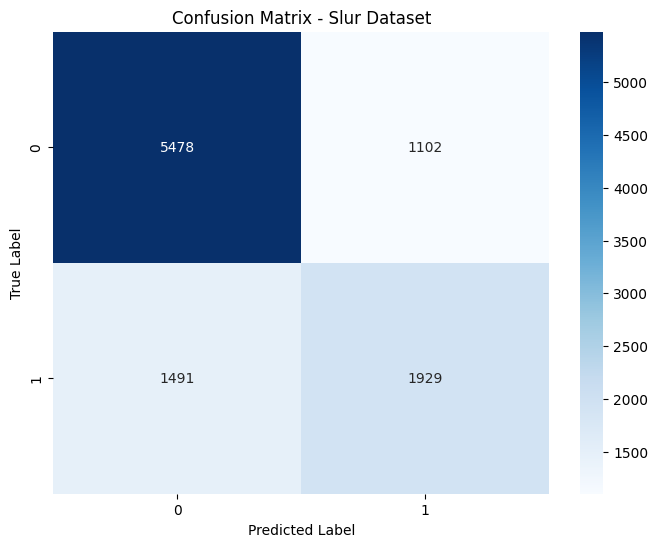

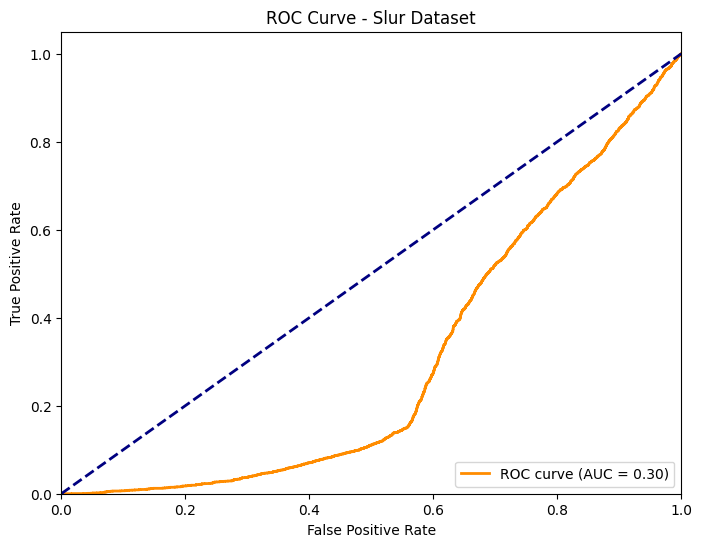

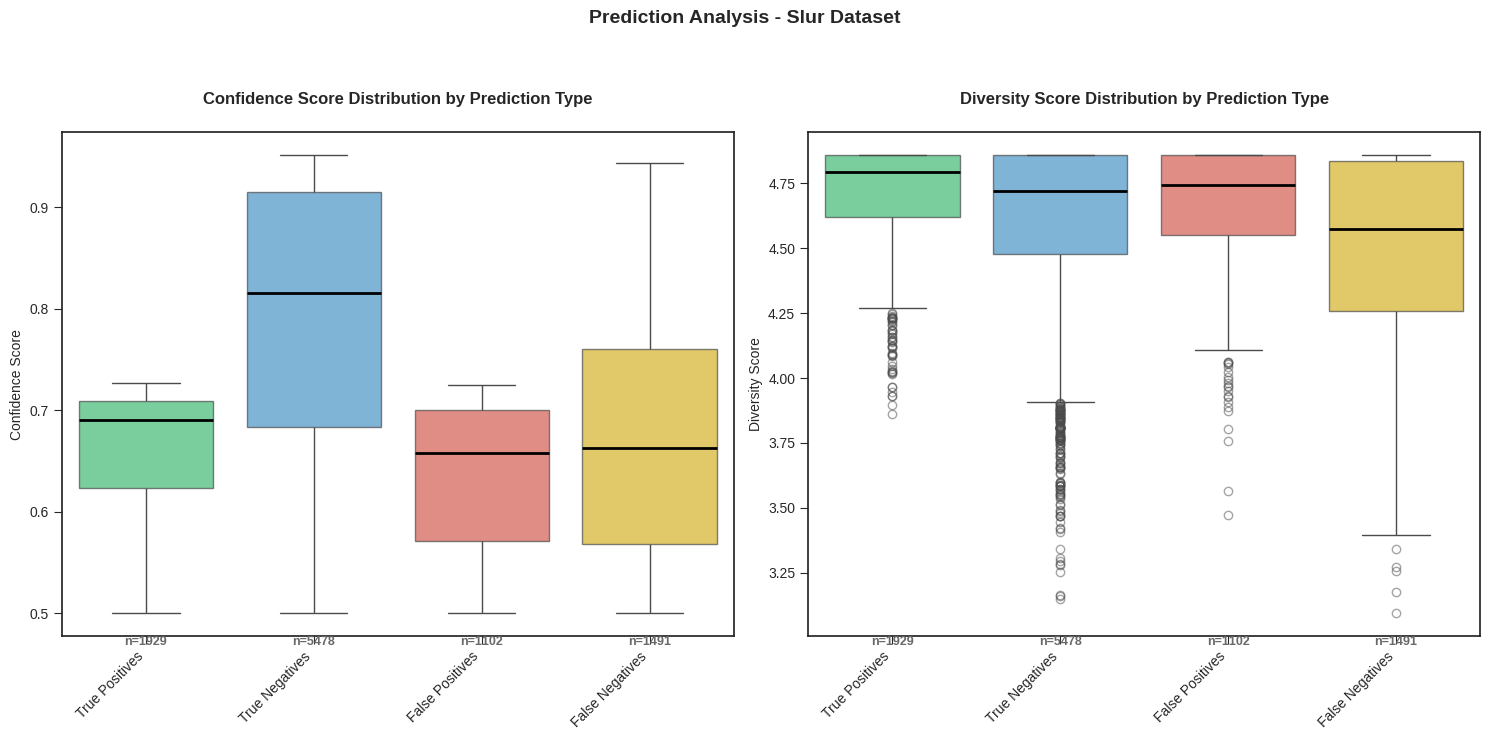


Evaluation Results for Slur Dataset dataset:
--------------------------------------------------
accuracy: 0.7407


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from typing import Dict, List, Tuple, Optional

def analyze_predictions(
    true_labels: np.ndarray,
    predicted_labels: np.ndarray,
    confidence_scores: np.ndarray,
    diversity_scores: np.ndarray,
    save_path: str,
    dataset_name: str
) -> Dict[str, np.ndarray]:
    """
    Analyze different types of predictions with enhanced visualization.
    """
    # Set the style
    plt.style.use('seaborn-v0_8-ticks')

    # Custom color scheme
    colors = {
        'True Positives': '#2ecc71',    # Green for correct positive predictions
        'True Negatives': '#3498db',    # Blue for correct negative predictions
        'False Positives': '#e74c3c',   # Red for false positives
        'False Negatives': '#f1c40f'    # Yellow for false negatives
    }

    # Identify different types of predictions
    prediction_types = {
        'True Positives': (true_labels == 1) & (predicted_labels == 1),
        'True Negatives': (true_labels == 0) & (predicted_labels == 0),
        'False Positives': (true_labels == 0) & (predicted_labels == 1),
        'False Negatives': (true_labels == 1) & (predicted_labels == 0)
    }

    # Create figure with larger size and higher DPI
    plt.figure(figsize=(15, 7), dpi=100)

    # Prepare data for confidence scores
    confidence_data = []
    confidence_labels = []
    for pred_type, mask in prediction_types.items():
        if np.any(mask):
            confidence_data.append(confidence_scores[mask])
            confidence_labels.extend([pred_type] * sum(mask))

    # Create DataFrame for confidence scores
    import pandas as pd
    df_confidence = pd.DataFrame({
        'Prediction Type': confidence_labels,
        'Confidence Score': np.concatenate(confidence_data)
    })

    # Plot confidence scores with enhanced styling
    plt.subplot(1, 2, 1)
    sns.boxplot(
        data=df_confidence,
        x='Prediction Type',
        y='Confidence Score',
        palette=colors,
        boxprops={'alpha': 0.7},
        showfliers=True,  # Show outlier points
        flierprops={'marker': 'o', 'alpha': 0.5},
        medianprops={'color': 'black', 'linewidth': 2},
        whis=1.5  # Set whisker length to 1.5 IQR
    )

    plt.xticks(rotation=45, ha='right')
    plt.title('Confidence Score Distribution by Prediction Type',
              pad=20, fontsize=12, fontweight='bold')
    plt.ylabel('Confidence Score', fontsize=10)
    plt.xlabel('')

    # Prepare data for diversity scores
    diversity_data = []
    diversity_labels = []
    for pred_type, mask in prediction_types.items():
        if np.any(mask):
            diversity_data.append(diversity_scores[mask])
            diversity_labels.extend([pred_type] * sum(mask))

    # Create DataFrame for diversity scores
    df_diversity = pd.DataFrame({
        'Prediction Type': diversity_labels,
        'Diversity Score': np.concatenate(diversity_data)
    })

    # Plot diversity scores with enhanced styling
    plt.subplot(1, 2, 2)
    sns.boxplot(
        data=df_diversity,
        x='Prediction Type',
        y='Diversity Score',
        palette=colors,
        boxprops={'alpha': 0.7},
        showfliers=True,
        flierprops={'marker': 'o', 'alpha': 0.5},
        medianprops={'color': 'black', 'linewidth': 2},
        whis=1.5
    )

    plt.xticks(rotation=45, ha='right')
    plt.title('Diversity Score Distribution by Prediction Type',
              pad=20, fontsize=12, fontweight='bold')
    plt.ylabel('Diversity Score', fontsize=10)
    plt.xlabel('')

    # Add a super title for the entire figure
    plt.suptitle(f'Prediction Analysis - {dataset_name}',
                 y=1.05, fontsize=14, fontweight='bold')

    # Adjust layout and add grid
    plt.tight_layout()

    # Add prediction counts in the plot
    for i, (ax, metric) in enumerate([('Confidence', confidence_data),
                                    ('Diversity', diversity_data)]):
        plt.subplot(1, 2, i+1)
        ylim = plt.gca().get_ylim()
        for j, (pred_type, data) in enumerate(zip(prediction_types.keys(), metric)):
            count = len(data)
            plt.text(j, ylim[0], f'n={count}',
                    ha='center', va='top', fontsize=9,
                    color='dimgray', fontweight='bold')

    # Save the figure
    plt.show()
    plt.savefig(f'{save_path}/prediction_analysis_{dataset_name}.png',
                bbox_inches='tight', dpi=300)
    plt.close()

    return prediction_types

def evaluate_and_visualize(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    save_path: str = "evaluation_results/",
    dataset_name: str = "test"
) -> Tuple[List[int], Dict[str, float], Optional[List[np.ndarray]]]:
    """
    Evaluate model and create visualizations for analysis.

    Args:
        model: The trained model
        data_loader: DataLoader for the evaluation dataset
        criterion: Loss function
        save_path: Directory to save visualizations
        dataset_name: Name of the dataset for plot titles

    Returns:
        Tuple of predictions, metrics, and attention weights
    """
    # Create save directory if it doesn't exist
    import os
    os.makedirs(save_path, exist_ok=True)

    # Get predictions and metrics
    model.eval()
    all_predictions = []
    all_labels = []
    all_confidence_scores = []
    all_diversity_scores = []
    attention_weights = []

    with torch.no_grad():
        for batch in data_loader:
            # Assuming the same batch structure as in the original evaluate function
            attn_mask, node_features, in_degree, out_degree, spatial_pos, attn_edge_type, attn_bias, labels = batch

            # Move inputs to device
            device = next(model.parameters()).device
            inputs = {
                'input_nodes': node_features.to(device),
                'input_edges': in_degree.to(device),
                'attn_bias': attn_bias.to(device),
                'in_degree': in_degree.to(device),
                'out_degree': out_degree.to(device),
                'spatial_pos': spatial_pos.to(device),
                'attn_edge_type': attn_edge_type.to(device)
            }

            # Forward pass
            outputs = model(**inputs)
            logits = outputs.logits

            # Get predictions and confidence scores
            if logits.dim() == 1:
                logits = logits.unsqueeze(-1)
                logits = torch.cat([1 - logits, logits], dim=1)

            probabilities = torch.softmax(logits, dim=1)
            confidence, predictions = torch.max(probabilities, dim=1)

            # Store results
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidence_scores.extend(confidence.cpu().numpy())
            all_diversity_scores.extend(outputs.diversity_scores.mean(dim=1).cpu().numpy())

            if hasattr(outputs, 'attention_weights') and outputs.attention_weights is not None:
                attention_weights.append(outputs.attention_weights.cpu().numpy())

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_confidence_scores = np.array(all_confidence_scores)
    all_diversity_scores = np.array(all_diversity_scores)

    # Calculate metrics
    metrics = {
        'accuracy': np.mean(all_predictions == all_labels),
        'diversity_scores': all_diversity_scores,
    }

    # Create visualizations
    # 1. Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(all_labels, all_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    plt.savefig(f'{save_path}/confusion_matrix_{dataset_name}.png')
    plt.close()

    # 2. ROC Curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(all_labels, all_confidence_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()
    plt.savefig(f'{save_path}/roc_curve_{dataset_name}.png')
    plt.close()

    # 3. Analyze predictions with boxplots
    prediction_types = analyze_predictions(
        all_labels,
        all_predictions,
        all_confidence_scores,
        all_diversity_scores,
        save_path,
        dataset_name
    )

    # Add prediction type metrics
    for pred_type, mask in prediction_types.items():
        metrics[f'{pred_type.lower().replace(" ", "_")}_count'] = np.sum(mask)
        if np.any(mask):
            metrics[f'{pred_type.lower().replace(" ", "_")}_avg_confidence'] = np.mean(all_confidence_scores[mask])
            metrics[f'{pred_type.lower().replace(" ", "_")}_avg_diversity'] = np.mean(all_diversity_scores[mask])

    # Print detailed metrics
    print(f"\nEvaluation Results for {dataset_name} dataset:")
    print("-" * 50)
    for metric_name, value in metrics.items():
        if isinstance(value, (float, int)):
            print(f"{metric_name}: {value:.4f}")

    return all_predictions, metrics, attention_weights

predictions, metrics, attention_weights = evaluate_and_visualize(
    model,
    data_loader,
    criterion,
    save_path="evaluation_results/",
    dataset_name="Slur Dataset"
)

In [ ]:
val_predictions, val_metrics, _ = evaluate(model, val_data_loader, criterion)

In [ ]:
# Generate classification report
report = classification_report(val_labels, val_predictions, target_names=['Class 0', 'Class 1'], output_dict=True)
print(classification_report(val_labels, val_predictions, target_names=['Class 0', 'Class 1']))

              precision    recall  f1-score   support

     Class 0       0.58      0.97      0.72       103
     Class 1       0.25      0.01      0.03        74

    accuracy                           0.57       177
   macro avg       0.41      0.49      0.38       177
weighted avg       0.44      0.57      0.43       177



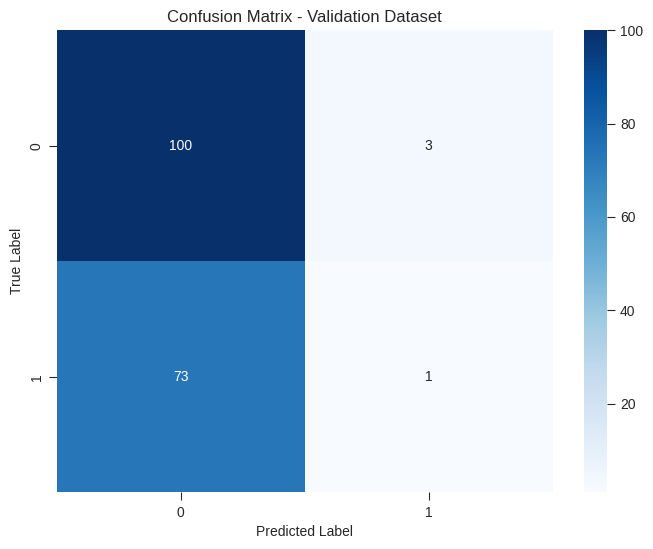

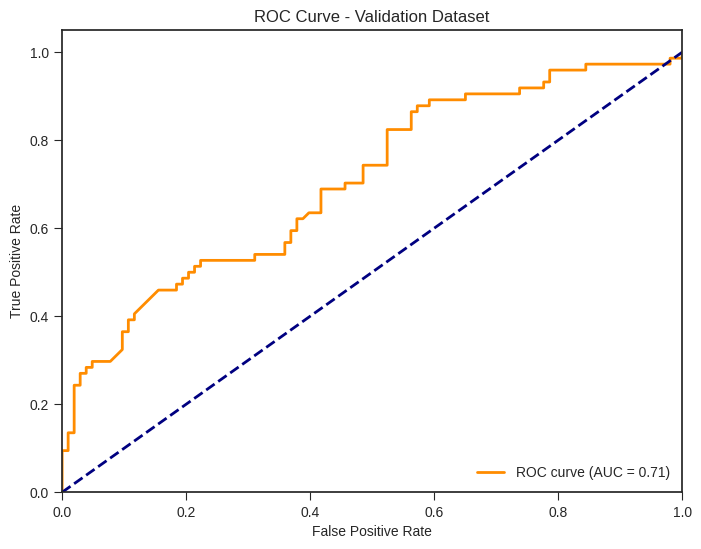

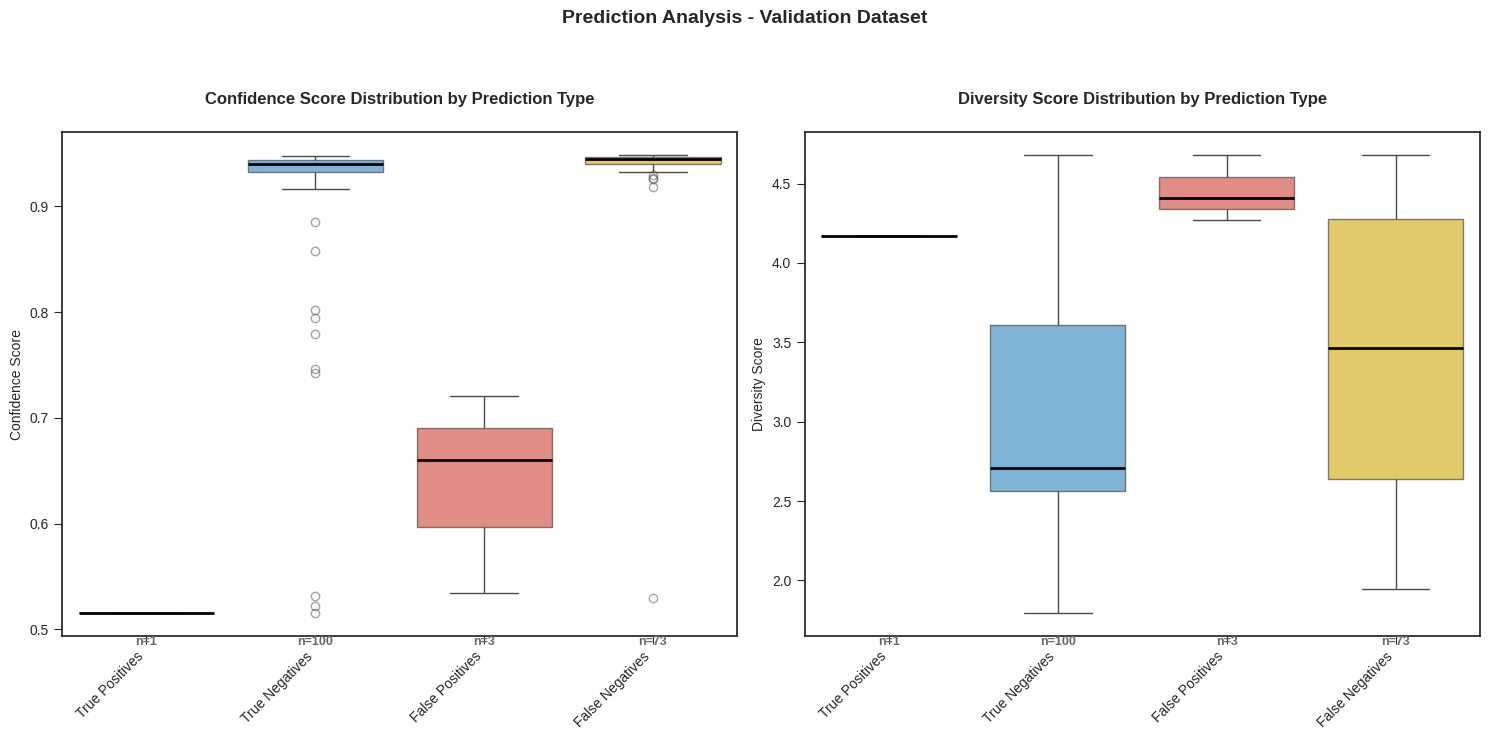


Evaluation Results for Validation Dataset dataset:
--------------------------------------------------
accuracy: 0.5706


In [ ]:
predictions, metrics, attention_weights = evaluate_and_visualize(
    model,
    val_data_loader,
    criterion,
    save_path="evaluation_results/",
    dataset_name="Validation Dataset"
)

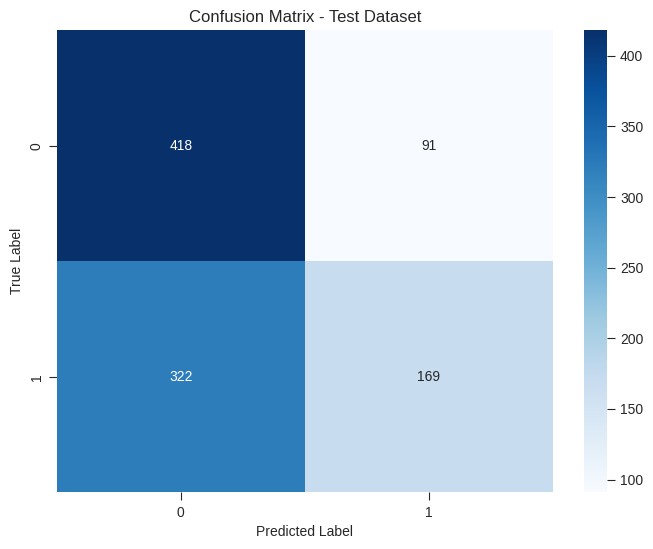

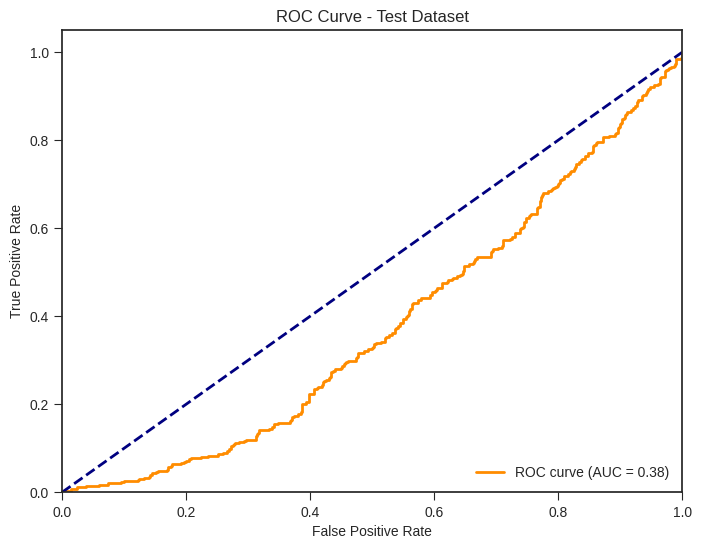

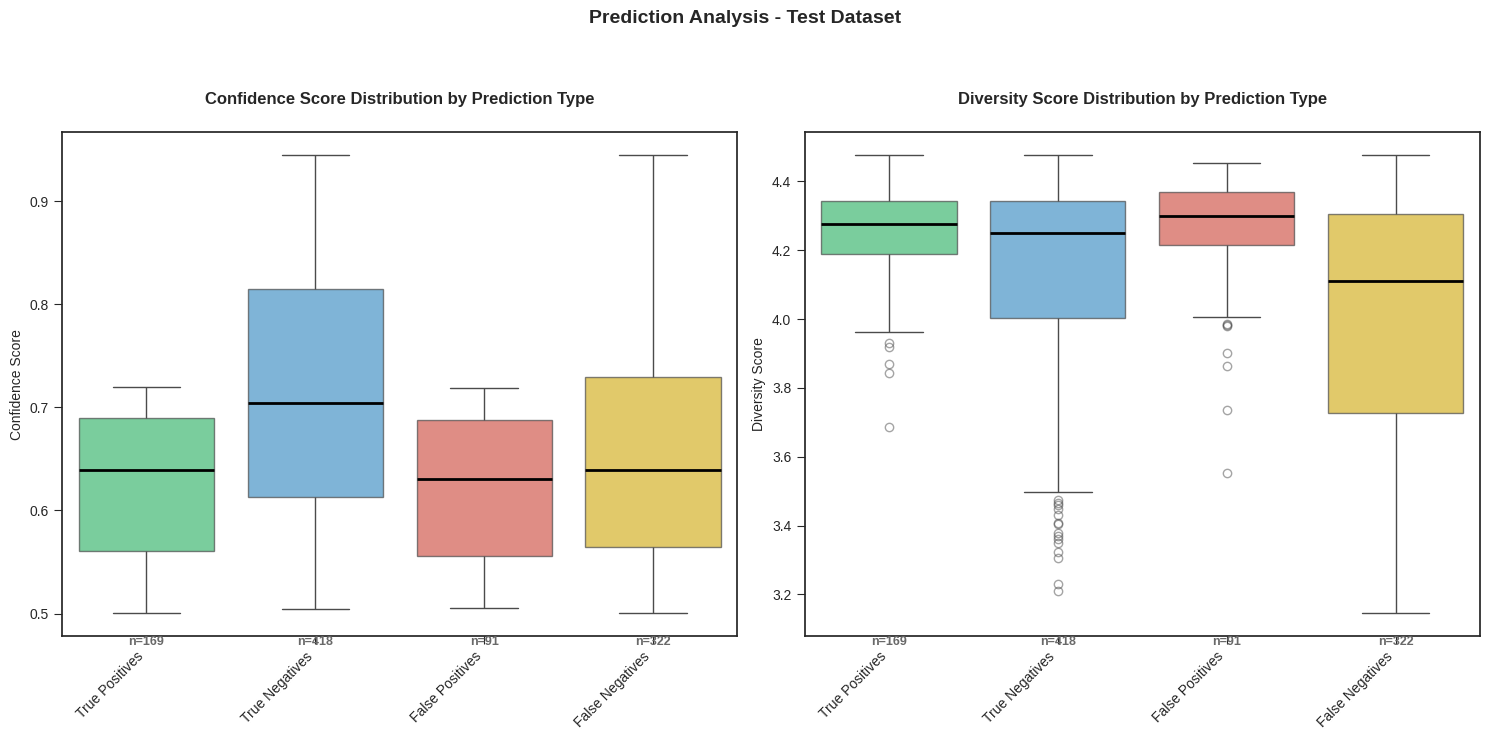


Evaluation Results for Test Dataset dataset:
--------------------------------------------------
accuracy: 0.5870


In [ ]:
predictions, metrics, attention_weights = evaluate_and_visualize(
    model,
    slur_data_loader,
    criterion,
    save_path="evaluation_results/",
    dataset_name="Test Dataset"
)

In [ ]:
# Generate classification report
report = classification_report(val_labels, val_predictions, target_names=['Class 0', 'Class 1'], output_dict=True)
print(classification_report(val_labels, val_predictions, target_names=['Class 0', 'Class 1']))

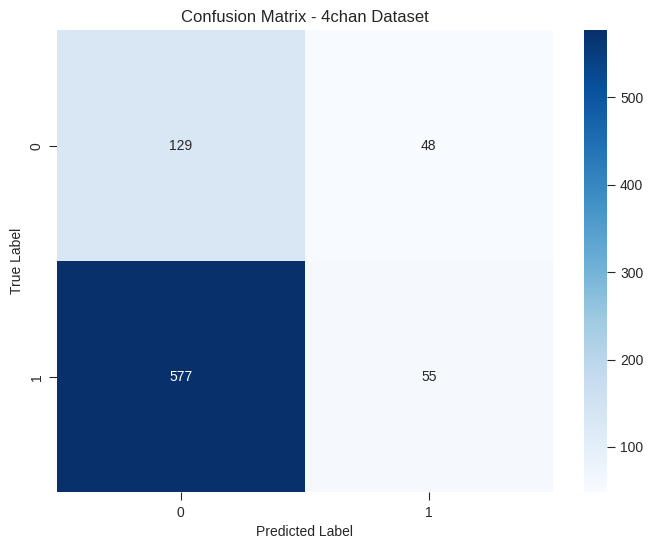

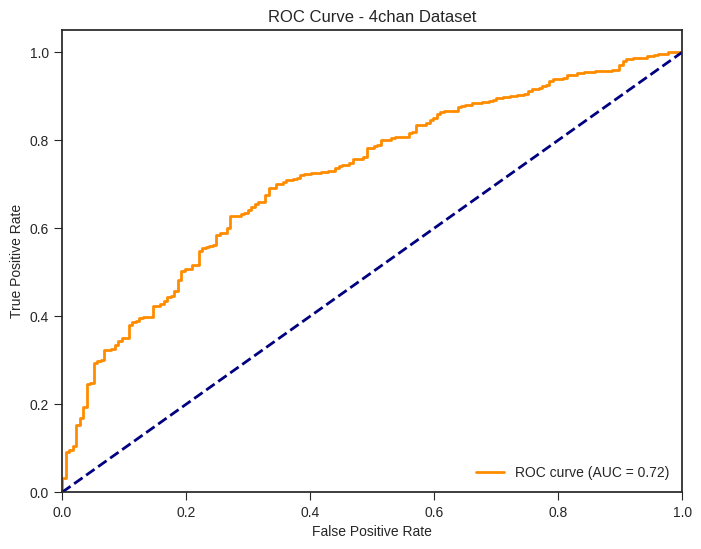

<ipython-input-39-cd24963a193d>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
<ipython-input-39-cd24963a193d>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


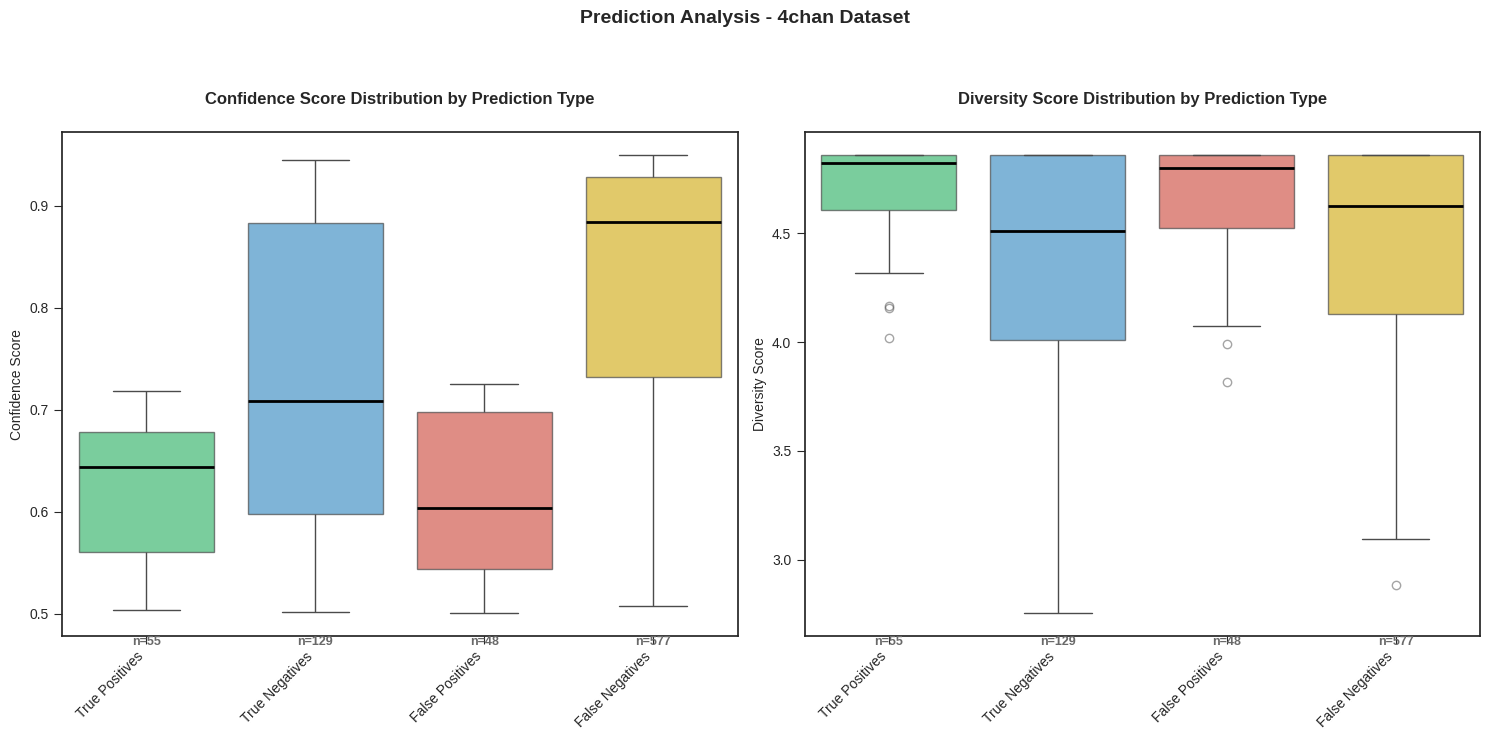


Evaluation Results for 4chan Dataset dataset:
--------------------------------------------------
accuracy: 0.2274


In [45]:
predictions, metrics, attention_weights = evaluate_and_visualize(
    model,
    chan_data_loader,
    criterion,
    save_path="evaluation_results/",
    dataset_name="4chan Dataset"
)

In [46]:
# Generate classification report
print(classification_report(chan_labels, predictions, target_names=['Class 0', 'Class 1']))

              precision    recall  f1-score   support

     Class 0       0.21      0.83      0.33       177
     Class 1       0.71      0.12      0.20       632

    accuracy                           0.27       809
   macro avg       0.46      0.47      0.27       809
weighted avg       0.60      0.27      0.23       809



## MultiGraphormer

In [ ]:
from torch.nn.utils import clip_grad_norm_
from transformers import AdamW, GraphormerConfig, GraphormerForGraphClassification
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
sarc_normalized_embeddings = normalize_embeddings(sarc_embeddings)
num_bins = 256
sarc_quantized_embeddings = quantize_embeddings(sarc_normalized_embeddings, num_bins=num_bins)

In [ ]:
torch.cuda.empty_cache()
gc.collect()

42528

In [ ]:
graphs2, labels2 = create_dgl_graphs(df_posts3, sarc_input_ids, sarc_attention_masks, sarc_quantized_embeddings, 'text', 'label')
sarc_dataset = GraphDataset(graphs2, labels2)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
from sklearn.model_selection import train_test_split

sarcasm_train_dataset, sarcasm_val_dataset = train_test_split(sarc_dataset)
sarcasm_train_loader = DataLoader(sarcasm_train_dataset, batch_size=16, collate_fn=collate_fn, shuffle=True)
sarcasm_val_loader = DataLoader(sarcasm_val_dataset, batch_size=16, collate_fn=collate_fn, shuffle=False)

In [ ]:
hate_speech_train_loader = data_loader
hate_speech_val_loader = slur_data_loader

In [ ]:
torch.cuda.empty_cache()
gc.collect()

10344

In [ ]:
class DiversityAwareClassifier(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size

        # Graph-level prediction head
        self.graph_prediction_head = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(config.hidden_size, 2)
        )

        # Diversity scoring mechanism
        self.diversity_score = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size // 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(config.hidden_size // 2, 1)
        )

        # Attention mechanism for diversity
        self.attention = nn.MultiheadAttention(
            embed_dim=config.hidden_size,
            num_heads=4,
            dropout=0.1,
            batch_first=True
        )

    def forward(self, node_embeddings, graph_embedding):
        # Calculate attention weights
        attn_output, attention_weights = self.attention(
            node_embeddings,
            node_embeddings,
            node_embeddings
        )

        # Calculate diversity scores
        diversity_scores = self.diversity_score(attn_output).squeeze(-1)

        # Get graph-level predictions
        graph_predictions = self.graph_prediction_head(graph_embedding)

        return graph_predictions, diversity_scores, attention_weights

class EnhancedMultiTaskGraphormer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.graphormer = GraphormerForGraphClassification(config)

        # Node embedding processing
        self.node_embedding_proj = nn.Linear(config.hidden_size, config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size)
        self.dropout = nn.Dropout(0.2)

        # Enhanced pooling with attention
        self.pooling = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, config.hidden_size)),
            nn.Dropout(0.2)
        )

        # Shared representation layer
        self.shared_representation = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.GELU(),
            nn.Dropout(0.2)
        )

        # Task-specific diversity-aware classifiers
        self.hate_speech_classifier = DiversityAwareClassifier(config)
        self.sarcasm_classifier = DiversityAwareClassifier(config)

    def forward(
        self,
        input_nodes=None,
        input_edges=None,
        attn_bias=None,
        in_degree=None,
        out_degree=None,
        spatial_pos=None,
        attn_edge_type=None,
        return_dict=True,
    ):
        # Get base Graphormer outputs
        outputs = self.graphormer(
            input_nodes=input_nodes,
            input_edges=input_edges,
            attn_bias=attn_bias,
            in_degree=in_degree,
            out_degree=out_degree,
            spatial_pos=spatial_pos,
            attn_edge_type=attn_edge_type,
            return_dict=True,
            output_hidden_states=True,
        )

        last_hidden_state = outputs.hidden_states[-1].transpose(0, 1)

        # Process node embeddings
        node_embeddings = self.node_embedding_proj(last_hidden_state)
        node_embeddings = self.layer_norm(node_embeddings)
        node_embeddings = self.dropout(node_embeddings)

        # Create graph-level embedding
        graph_embedding = torch.mean(node_embeddings, dim=1)

        # Get shared representation
        shared_rep = self.shared_representation(graph_embedding)

        # Task-specific predictions with diversity awareness
        hate_preds, hate_div_scores, hate_attn = self.hate_speech_classifier(
            node_embeddings, shared_rep
        )
        sarcasm_preds, sarcasm_div_scores, sarcasm_attn = self.sarcasm_classifier(
            node_embeddings, shared_rep
        )

        if not return_dict:
            return (
                hate_preds,
                sarcasm_preds,
                hate_div_scores,
                sarcasm_div_scores,
                hate_attn,
                sarcasm_attn
            )

        return {
            'hate_speech_logits': hate_preds,
            'sarcasm_logits': sarcasm_preds,
            'hate_diversity_scores': hate_div_scores,
            'sarcasm_diversity_scores': sarcasm_div_scores,
            'hate_attention_weights': hate_attn,
            'sarcasm_attention_weights': sarcasm_attn,
            'hidden_states': outputs.hidden_states,
            'attentions': outputs.attentions
        }

def create_model_and_optimizer(config, device, training_args):
    model = EnhancedMultiTaskGraphormer(config).to(device)

    # Separate parameter groups with different learning rates
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {
            'params': [p for n, p in model.named_parameters()
                      if not any(nd in n for nd in no_decay)],
            'weight_decay': training_args['weight_decay']
        },
        {
            'params': [p for n, p in model.named_parameters()
                      if any(nd in n for nd in no_decay)],
            'weight_decay': 0.0
        }
    ]

    optimizer = torch.optim.AdamW(
        optimizer_grouped_parameters,
        lr=training_args['learning_rate']
    )

    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=2,
        verbose=True,
        min_lr=1e-7
    )

    return model, optimizer, scheduler

def prepare_batch(batch):
    """Prepare batch data for model input"""
    attn_mask, node_features, in_degree, out_degree, spatial_pos, attn_edge_type, attn_bias, _ = batch

    return {
        'input_nodes': node_features.to(device),
        'input_edges': in_degree.to(device),
        'attn_bias': attn_bias.to(device),
        'in_degree': in_degree.to(device),
        'out_degree': out_degree.to(device),
        'spatial_pos': spatial_pos.to(device),
        'attn_edge_type': attn_edge_type.to(device)
    }

def compute_loss(logits, labels):
    return torch.nn.CrossEntropyLoss(
        label_smoothing=0.1
    )(logits, labels)

def calculate_metrics(labels, predictions):
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted'),
        'precision_recall': precision_recall_fscore_support(
            labels, predictions, average='weighted'
        )[:2]
    }

config = GraphormerConfig(
    num_classes=2,
    hidden_size=768,
    num_attention_heads=8,
    num_hidden_layers=6,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.1,
    edge_type="multi",
    num_edge_types=2,
    multi_hop_max_dist=4,
    ignore_mismatched_sizes=True,
    use_checkpoint=True,
    max_position_embeddings=512,
    layer_norm_eps=1e-5
)

training_args = {
    'learning_rate': 1e-6,
    'weight_decay': 0.01,
    'warmup_steps': 100,
    'gradient_accumulation_steps': 4,
    'max_grad_norm': 0.5,
    'batch_size': 16
}

In [ ]:
def evaluate(model, eval_loader, criterion, task):
    """
    Evaluate model on given data loader for specified task

    Args:
        model: The model to evaluate
        eval_loader: DataLoader containing evaluation data
        criterion: Loss criterion that handles both CE and diversity losses
        task: Either 'hate_speech' or 'sarcasm'
    """
    model.eval()
    total_loss = 0.0
    metrics = {
        'preds': [],
        'labels': [],
        'diversity_gaps': []
    }

    with torch.no_grad():
        for batch in tqdm(eval_loader, desc=f"Evaluating {task}"):
            # Prepare inputs
            inputs = prepare_batch(batch)
            labels = batch[-1].to(inputs['input_nodes'].device)

            # Forward pass
            outputs = model(**inputs)

            # Extract embeddings and compute diversity scores
            node_embeddings = outputs['hidden_states'][-1].transpose(0, 1)
            diversity_scores = torch.std(node_embeddings, dim=2)  # [batch_size, seq_len]

            # Get appropriate logits based on task
            logits = outputs['logits'] if 'logits' in outputs else outputs[f'{task}_logits']

            # Compute loss
            loss, ce_loss, div_loss = criterion(
                logits,
                labels,
                node_embeddings,
                diversity_scores
            )

            total_loss += loss.item()

            # Track predictions
            preds = torch.argmax(logits, dim=1)
            metrics['preds'].extend(preds.cpu().numpy())
            metrics['labels'].extend(labels.cpu().numpy())

            # Calculate diversity gap between positive and negative classes
            pos_mask = labels == 1
            neg_mask = labels == 0

            if torch.any(pos_mask) and torch.any(neg_mask):
                pos_div = diversity_scores[pos_mask].mean()
                neg_div = diversity_scores[neg_mask].mean()
                div_gap = torch.abs(pos_div - neg_div)
                metrics['diversity_gaps'].append(div_gap.item())

    # Calculate final metrics
    results = {
        'loss': total_loss / len(eval_loader),
        'f1': f1_score(
            metrics['labels'],
            metrics['preds'],
            average='weighted'
        ),
        'accuracy': accuracy_score(metrics['labels'], metrics['preds']),
        'precision_recall': precision_recall_fscore_support(
            metrics['labels'],
            metrics['preds'],
            average='weighted'
        )[:2],
        'diversity_gap': float(np.mean(metrics['diversity_gaps']))
            if metrics['diversity_gaps'] else 0.0
    }

    return results

In [ ]:
default_training_args = {
    'num_epochs': 10,
    'learning_rate': 2e-5,
    'weight_decay': 0.01,
    'scheduler_patience': 2,
    'early_stopping_patience': 3,
    'min_epochs': 5,
    'save_every_n_epochs': 5,
    'gradient_accumulation_steps': 1,
    'max_grad_norm': 1.0,
    'ce_loss_weight': 1.0,
    'diversity_loss_weight': 0.1,
    'output_dir': 'checkpoints'
}

In [ ]:
from datetime import datetime

In [ ]:
# Main training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, optimizer, scheduler = create_model_and_optimizer(config, device, training_args)
criterion = DiversityLoss(num_classes=2, alpha=1.0, beta=0.1)
num_epochs = 10

dataloaders = {
    'hate_speech_train': hate_speech_train_loader,
    'sarcasm_train': sarcasm_train_loader,
    'hate_speech_val': hate_speech_val_loader,
    'sarcasm_val': sarcasm_val_loader
}

model.load_state_dict(torch.load("HRSG.pt", weights_only=True))
model.eval()

<bound method Module.eval of EnhancedMultiTaskGraphormer(
  (graphormer): GraphormerForGraphClassification(
    (encoder): GraphormerModel(
      (graph_encoder): GraphormerGraphEncoder(
        (dropout_module): Dropout(p=0.1, inplace=False)
        (graph_node_feature): GraphormerGraphNodeFeature(
          (atom_encoder): Embedding(4609, 768, padding_idx=0)
          (in_degree_encoder): Embedding(512, 768, padding_idx=0)
          (out_degree_encoder): Embedding(512, 768, padding_idx=0)
          (graph_token): Embedding(1, 768)
        )
        (graph_attn_bias): GraphormerGraphAttnBias(
          (edge_encoder): Embedding(1537, 8, padding_idx=0)
          (spatial_pos_encoder): Embedding(512, 8, padding_idx=0)
          (graph_token_virtual_distance): Embedding(1, 8)
        )
        (layers): ModuleList(
          (0-5): 6 x GraphormerGraphEncoderLayer(
            (dropout_module): Dropout(p=0.1, inplace=False)
            (activation_dropout_module): Dropout(p=0.1, inplace=False)
            (activation_fn): GELUActivation()
            (self_attn): GraphormerMultiheadAttention(
              (attention_dropout_module): Dropout(p=0.1, inplace=False)
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (fc1): Linear(in_features=768, out_features=768, bias=True)
            (fc2): Linear(in_features=768, out_features=768, bias=True)
            (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
        )
      )
      (lm_head_transform_weight): Linear(in_features=768, out_features=768, bias=True)
      (activation_fn): GELUActivation()
      (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (classifier): GraphormerDecoderHead(
      (classifier): Linear(in_features=768, out_features=2, bias=False)
    )
  )
  (node_embedding_proj): Linear(in_features=768, out_features=768, bias=True)
  (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pooling): Sequential(
    (0): AdaptiveAvgPool2d(output_size=(1, 768))
    (1): Dropout(p=0.2, inplace=False)
  )
  (shared_representation): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.2, inplace=False)
  )
  (hate_speech_classifier): DiversityAwareClassifier(
    (graph_prediction_head): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): GELU(approximate='none')
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=768, out_features=2, bias=True)
    )
    (diversity_score): Sequential(
      (0): Linear(in_features=768, out_features=384, bias=True)
      (1): GELU(approximate='none')
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=384, out_features=1, bias=True)
    )
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
  )
  (sarcasm_classifier): DiversityAwareClassifier(
    (graph_prediction_head): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): GELU(approximate='none')
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=768, out_features=2, bias=True)
    )
    (diversity_score): Sequential(
      (0): Linear(in_features=768, out_features=384, bias=True)
      (1): GELU(approximate='none')
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=384, out_features=1, bias=True)
    )
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_featur

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score, precision_recall_fscore_support
from tqdm import tqdm

def evaluate_and_visualize(
    model: torch.nn.Module,
    eval_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    task: str,
    save_path: str = "evaluation_results/",
    dataset_name: str = "test"
) -> Tuple[np.ndarray, Dict[str, float], List[np.ndarray]]:
    """
    Evaluate model and create visualizations for analysis.

    Args:
        model: The trained model
        eval_loader: DataLoader containing evaluation data
        criterion: Loss criterion that handles both CE and diversity losses
        task: Either 'hate_speech' or 'sarcasm'
        save_path: Directory to save visualizations
        dataset_name: Name of the dataset for plot titles

    Returns:
        Tuple of predictions, metrics, and diversity scores
    """
    # Create save directory if it doesn't exist
    import os
    os.makedirs(save_path, exist_ok=True)

    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_labels = []
    all_confidence_scores = []
    all_diversity_scores = []
    diversity_gaps = []

    with torch.no_grad():
        for batch in tqdm(eval_loader, desc=f"Evaluating {task}"):
            # Prepare inputs
            inputs = prepare_batch(batch)
            labels = batch[-1].to(inputs['input_nodes'].device)

            # Forward pass
            outputs = model(**inputs)

            # Extract embeddings and compute diversity scores
            node_embeddings = outputs['hidden_states'][-1].transpose(0, 1)
            diversity_scores = torch.std(node_embeddings, dim=2)  # [batch_size, seq_len]

            # Get appropriate logits based on task
            logits = outputs['logits'] if 'logits' in outputs else outputs[f'{task}_logits']

            # Compute loss
            loss, ce_loss, div_loss = criterion(
                logits,
                labels,
                node_embeddings,
                diversity_scores
            )

            total_loss += loss.item()

            # Get predictions and confidence scores
            probabilities = torch.softmax(logits, dim=1)
            confidence, predictions = torch.max(probabilities, dim=1)

            # Store results
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidence_scores.extend(confidence.cpu().numpy())
            all_diversity_scores.extend(diversity_scores.mean(dim=1).cpu().numpy())

            # Calculate diversity gap between positive and negative classes
            pos_mask = labels == 1
            neg_mask = labels == 0

            if torch.any(pos_mask) and torch.any(neg_mask):
                pos_div = diversity_scores[pos_mask].mean()
                neg_div = diversity_scores[neg_mask].mean()
                div_gap = torch.abs(pos_div - neg_div)
                diversity_gaps.append(div_gap.item())

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_confidence_scores = np.array(all_confidence_scores)
    all_diversity_scores = np.array(all_diversity_scores)

    # Calculate metrics
    metrics = {
        'loss': total_loss / len(eval_loader),
        'accuracy': accuracy_score(all_labels, all_predictions),
        'f1': f1_score(all_labels, all_predictions, average='weighted'),
        'diversity_gap': float(np.mean(diversity_gaps)) if diversity_gaps else 0.0
    }

    precision, recall = precision_recall_fscore_support(
        all_labels,
        all_predictions,
        average='weighted'
    )[:2]
    metrics['precision'] = precision
    metrics['recall'] = recall

    # Create visualizations with custom color scheme
    colors = {
        'True Positives': '#2ecc71',
        'True Negatives': '#3498db',
        'False Positives': '#e74c3c',
        'False Negatives': '#f1c40f'
    }

    # 1. Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(all_labels, all_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {dataset_name} ({task})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f'{save_path}/confusion_matrix_{task}_{dataset_name}.png')
    plt.show()
    plt.close()

    # 2. ROC Curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(all_labels, all_confidence_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_name} ({task})')
    plt.legend(loc="lower right")
    plt.savefig(f'{save_path}/roc_curve_{task}_{dataset_name}.png')
    plt.show()
    plt.close()

    # 3. Prediction Analysis
    prediction_types = {
        'True Positives': (all_labels == 1) & (all_predictions == 1),
        'True Negatives': (all_labels == 0) & (all_predictions == 0),
        'False Positives': (all_labels == 0) & (all_predictions == 1),
        'False Negatives': (all_labels == 1) & (all_predictions == 0)
    }

    plt.figure(figsize=(15, 7), dpi=100)

    # Confidence Score Distribution
    plt.subplot(1, 2, 1)
    confidence_data = []
    confidence_labels = []
    for pred_type, mask in prediction_types.items():
        if np.any(mask):
            confidence_data.append(all_confidence_scores[mask])
            confidence_labels.extend([pred_type] * sum(mask))

    df_confidence = pd.DataFrame({
        'Prediction Type': confidence_labels,
        'Confidence Score': np.concatenate(confidence_data)
    })

    sns.boxplot(
        data=df_confidence,
        x='Prediction Type',
        y='Confidence Score',
        palette=colors,
        boxprops={'alpha': 0.7},
        showfliers=True,
        flierprops={'marker': 'o', 'alpha': 0.5},
        medianprops={'color': 'black', 'linewidth': 2}
    )

    plt.xticks(rotation=45, ha='right')
    plt.title(f'Confidence Score Distribution - {task}',
              pad=20, fontsize=12, fontweight='bold')

    # Diversity Score Distribution
    plt.subplot(1, 2, 2)
    diversity_data = []
    diversity_labels = []
    for pred_type, mask in prediction_types.items():
        if np.any(mask):
            diversity_data.append(all_diversity_scores[mask])
            diversity_labels.extend([pred_type] * sum(mask))

    df_diversity = pd.DataFrame({
        'Prediction Type': diversity_labels,
        'Diversity Score': np.concatenate(diversity_data)
    })

    sns.boxplot(
        data=df_diversity,
        x='Prediction Type',
        y='Diversity Score',
        palette=colors,
        boxprops={'alpha': 0.7},
        showfliers=True,
        flierprops={'marker': 'o', 'alpha': 0.5},
        medianprops={'color': 'black', 'linewidth': 2}
    )

    plt.xticks(rotation=45, ha='right')
    plt.title(f'Diversity Score Distribution - {task}',
              pad=20, fontsize=12, fontweight='bold')

    plt.suptitle(f'Prediction Analysis - {dataset_name}',
                 y=1.05, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{save_path}/prediction_analysis_{task}_{dataset_name}.png',
                bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

    # Print metrics
    print(f"\nEvaluation Results for {dataset_name} dataset ({task}):")
    print("-" * 50)
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

    print(classification_report(all_labels, all_predictions, target_names=['Class 0', 'Class 1']))

    return all_predictions, metrics, all_diversity_scores

Evaluating hate_speech: 100%|██████████| 625/625 [01:09<00:00,  8.95it/s]


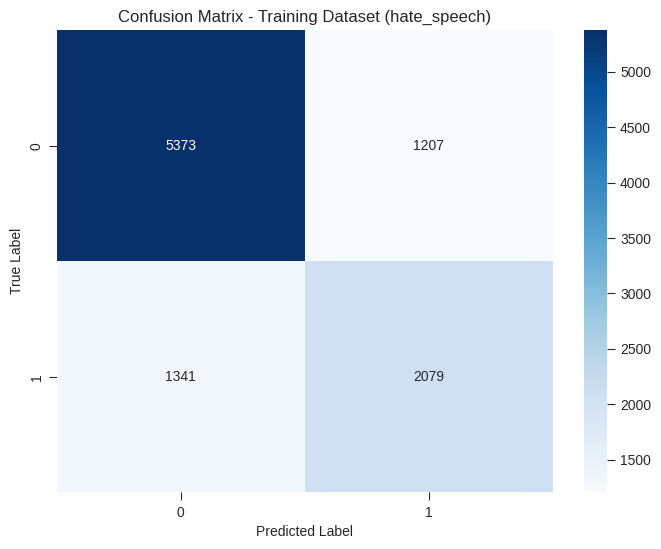

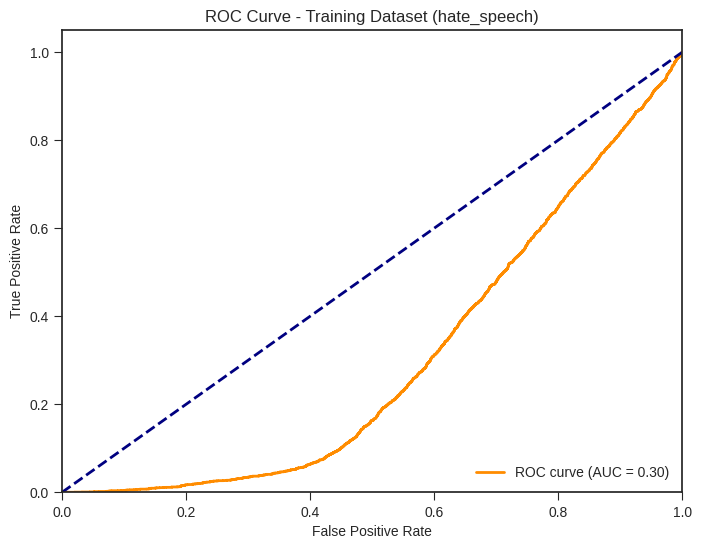

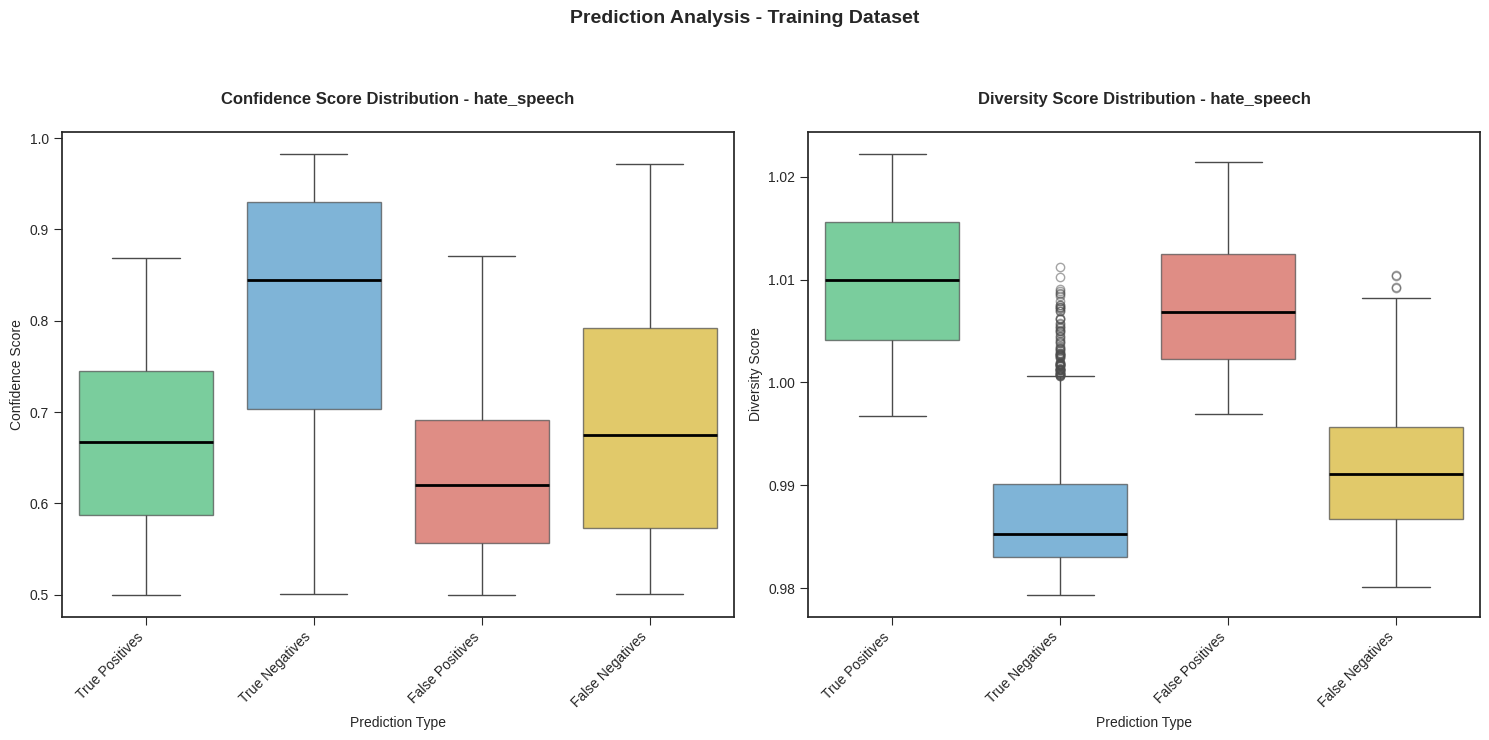


Evaluation Results for Training Dataset dataset (hate_speech):
--------------------------------------------------
loss: 0.5046
accuracy: 0.7452
f1: 0.7439
diversity_gap: 0.0126
precision: 0.7430
recall: 0.7452
              precision    recall  f1-score   support

     Class 0       0.80      0.82      0.81      6580
     Class 1       0.63      0.61      0.62      3420

    accuracy                           0.75     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.74      0.75      0.74     10000



In [ ]:
predictions, metrics, diversity_scores = evaluate_and_visualize(
    model,
    data_loader,
    criterion,
    task="hate_speech",  # or "sarcasm"
    save_path="evaluation_results/",
    dataset_name="Training Dataset"
)

Evaluating hate_speech: 100%|██████████| 63/63 [00:04<00:00, 12.72it/s]


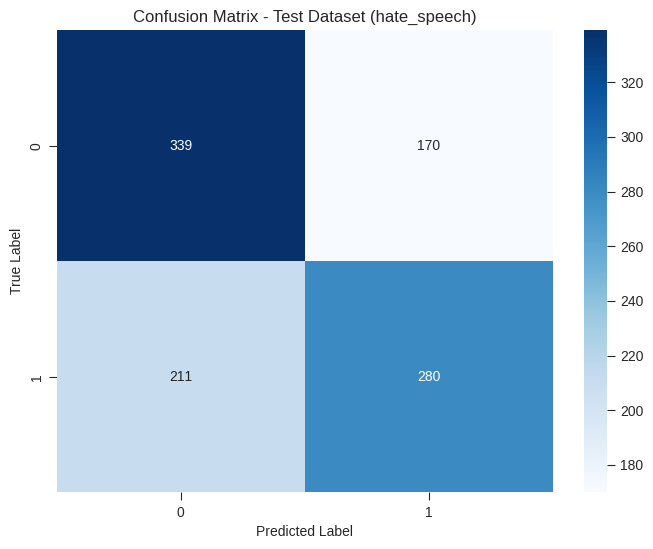

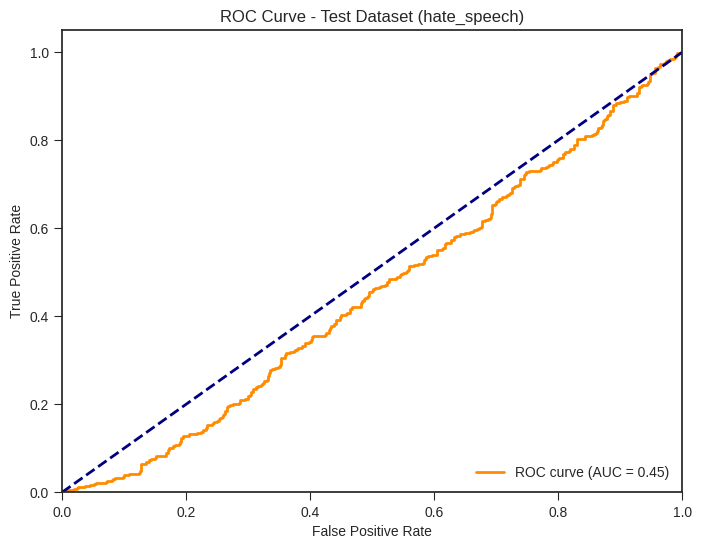

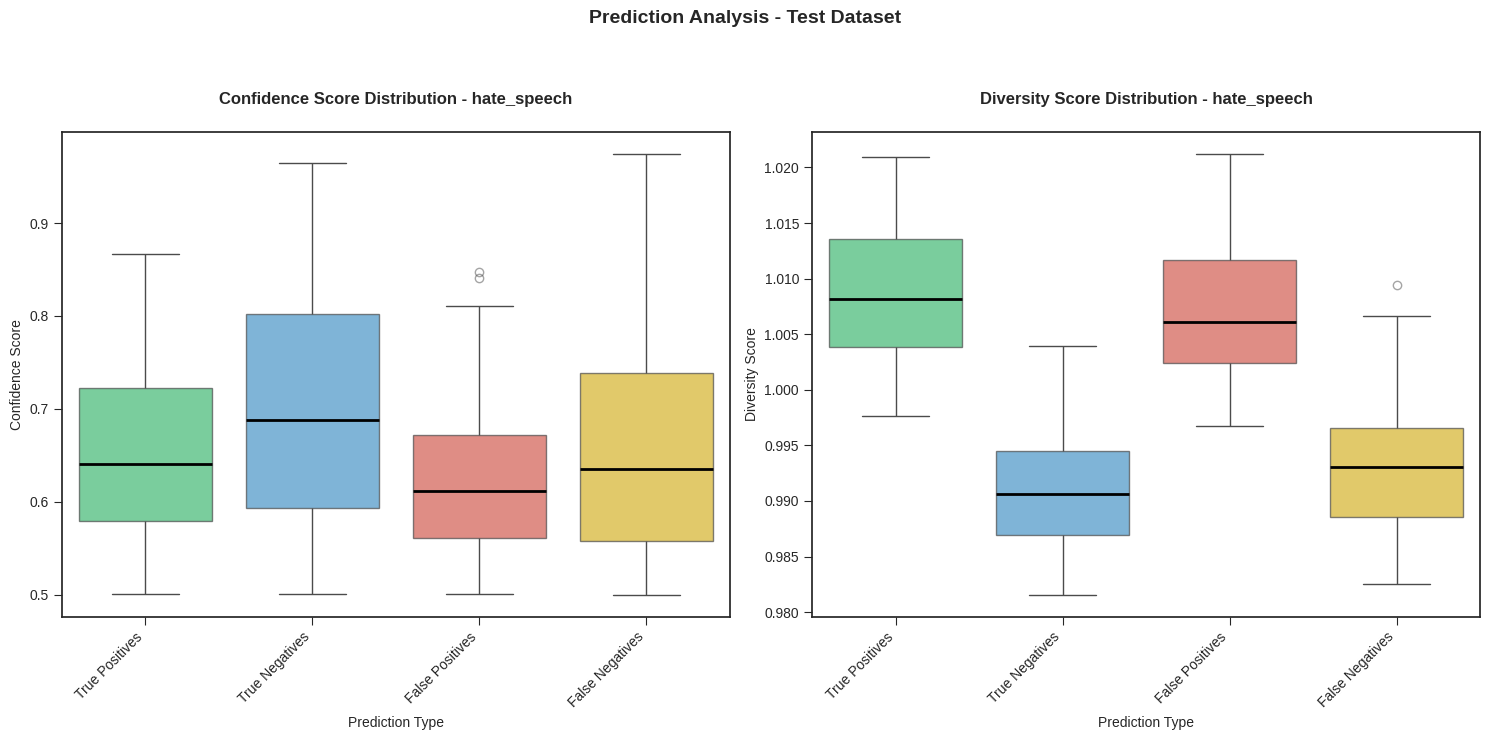


Evaluation Results for Test Dataset dataset (hate_speech):
--------------------------------------------------
loss: 0.6600
accuracy: 0.6190
f1: 0.6181
diversity_gap: 0.0060
precision: 0.6192
recall: 0.6190
              precision    recall  f1-score   support

     Class 0       0.62      0.67      0.64       509
     Class 1       0.62      0.57      0.60       491

    accuracy                           0.62      1000
   macro avg       0.62      0.62      0.62      1000
weighted avg       0.62      0.62      0.62      1000



In [ ]:
predictions, metrics, diversity_scores = evaluate_and_visualize(
    model,
    slur_data_loader,
    criterion,
    task="hate_speech",  # or "sarcasm"
    save_path="evaluation_results/",
    dataset_name="Test Dataset"
)

Evaluating hate_speech: 100%|██████████| 12/12 [00:00<00:00, 18.51it/s]


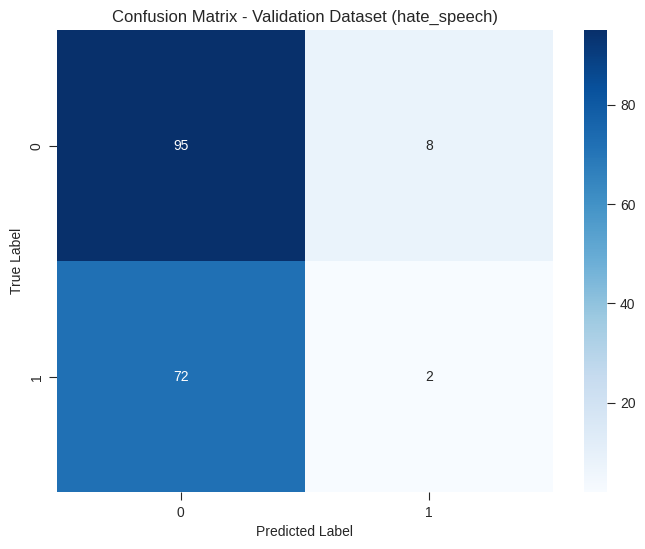

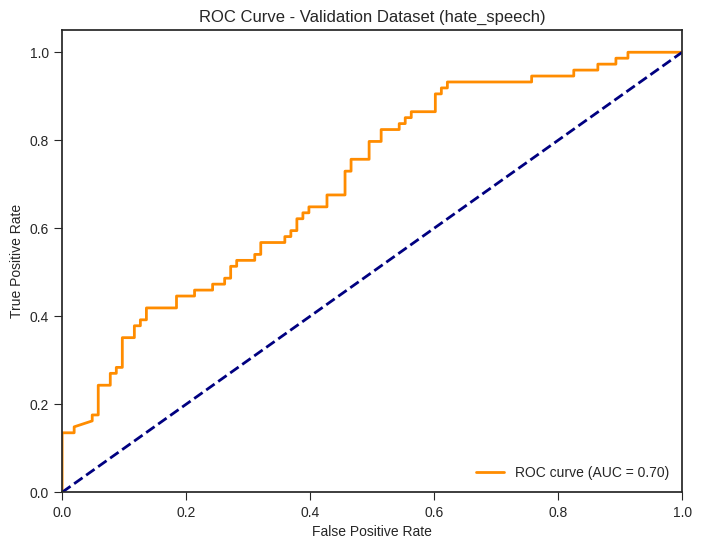

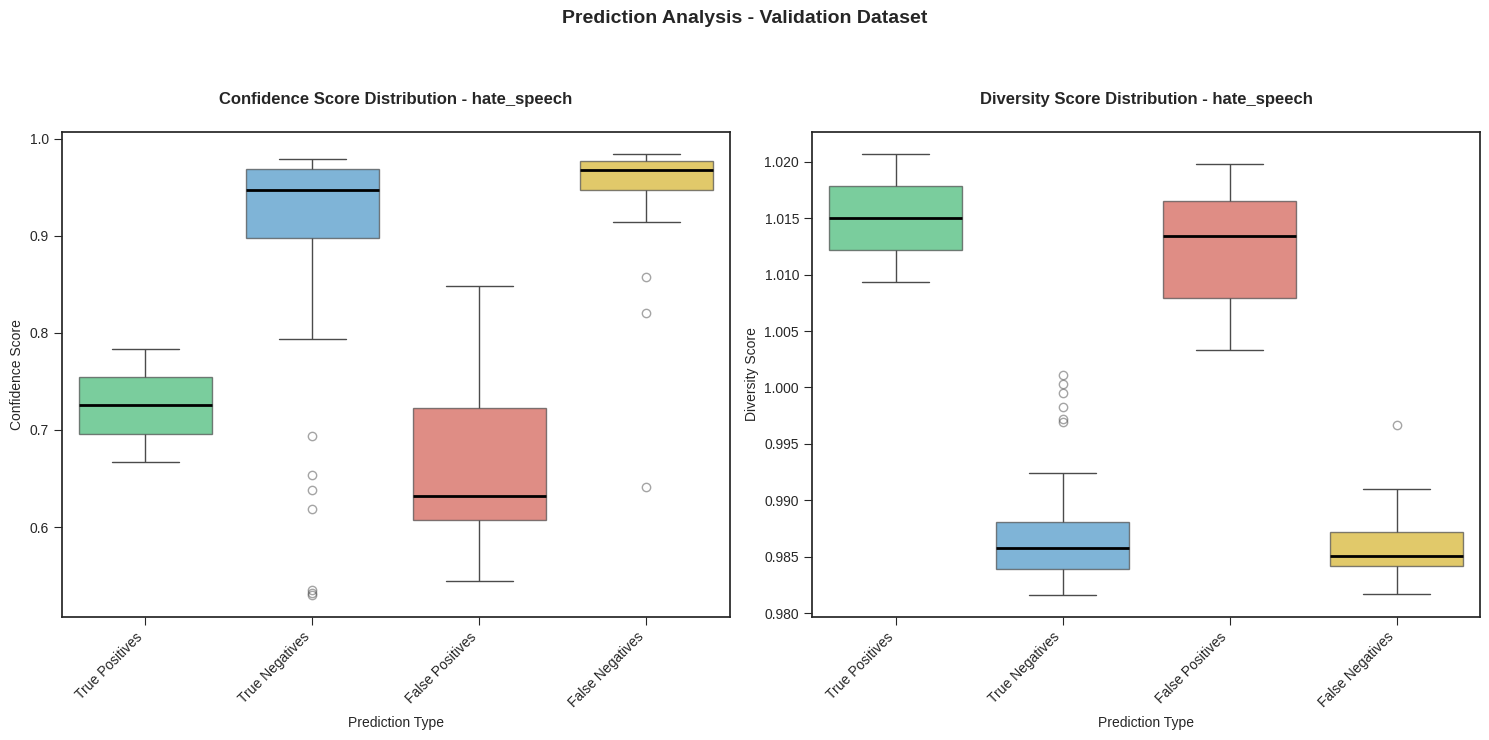


Evaluation Results for Validation Dataset dataset (hate_speech):
--------------------------------------------------
loss: 1.3740
accuracy: 0.5480
f1: 0.4294
diversity_gap: 0.0034
precision: 0.4146
recall: 0.5480
              precision    recall  f1-score   support

     Class 0       0.57      0.92      0.70       103
     Class 1       0.20      0.03      0.05        74

    accuracy                           0.55       177
   macro avg       0.38      0.47      0.38       177
weighted avg       0.41      0.55      0.43       177



In [ ]:
val_pred, metrics, diversity_scores = evaluate_and_visualize(
    model,
    val_data_loader,
    criterion,
    task="hate_speech",  # or "sarcasm"
    save_path="evaluation_results/",
    dataset_name="Validation Dataset"
)

In [ ]:
val_hrg = pd.DataFrame({'Text': val_df['text'],
                   'Og labels': val_labels,
                   'Predictions': val_pred})

val_hrg.to_csv('val_hsrg.csv', index=False)

Evaluating hate_speech: 100%|██████████| 51/51 [00:04<00:00, 10.43it/s]


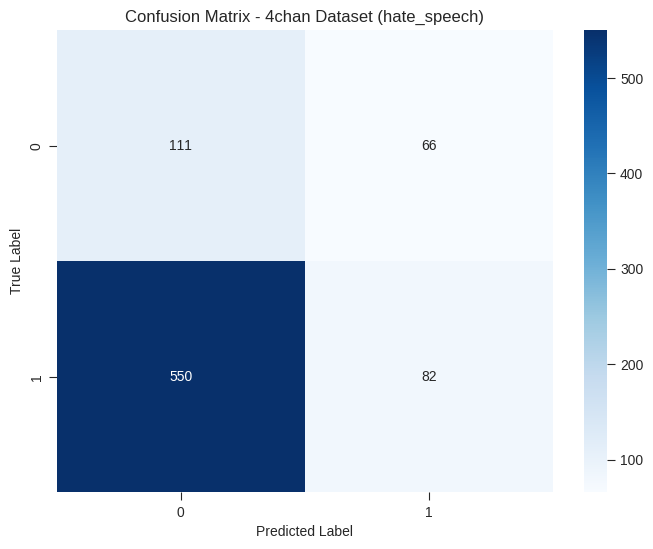

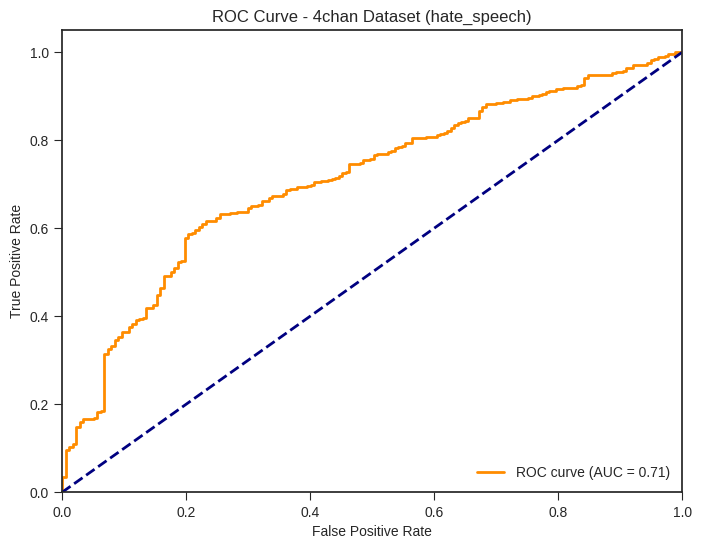

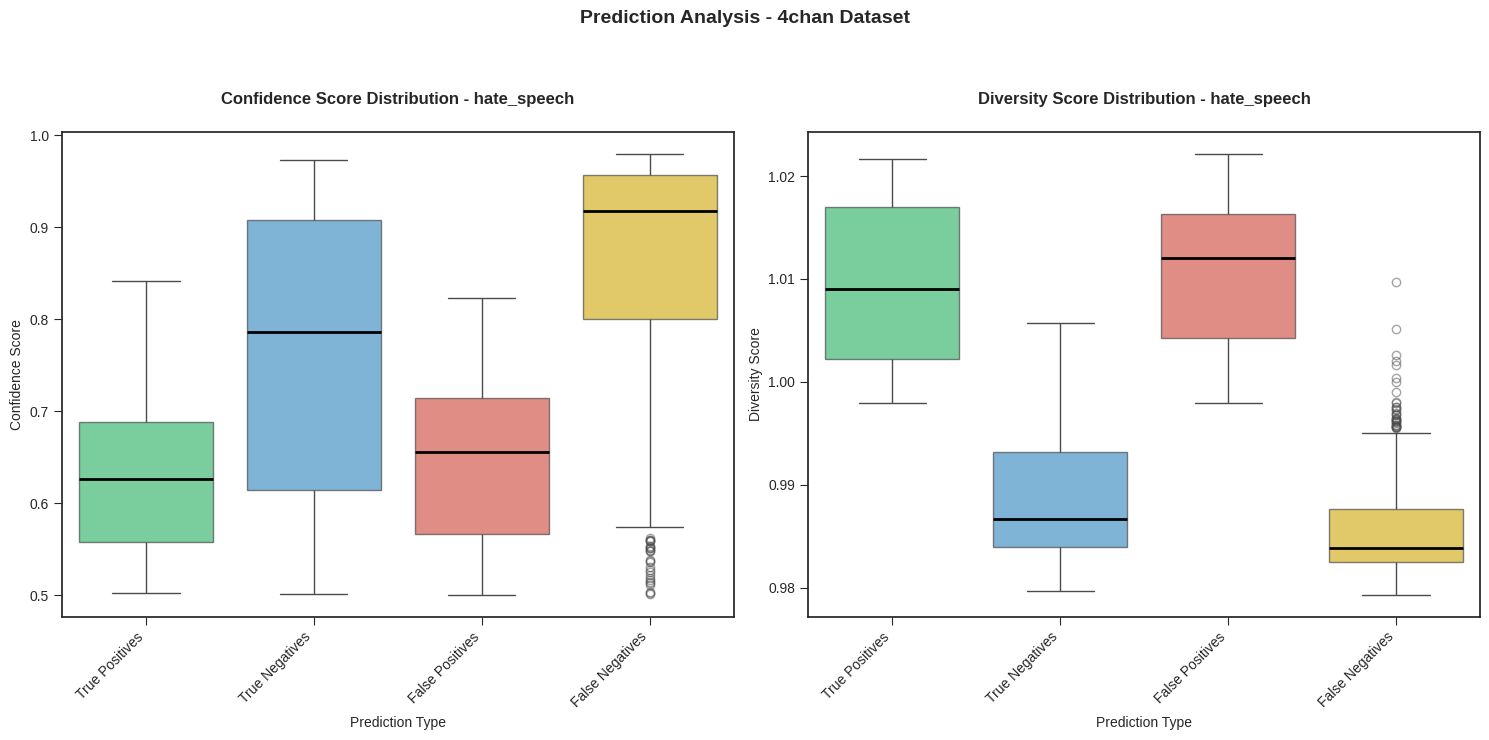


Evaluation Results for 4chan Dataset dataset (hate_speech):
--------------------------------------------------
loss: 1.7765
accuracy: 0.2386
f1: 0.2222
diversity_gap: 0.0092
precision: 0.4696
recall: 0.2386
              precision    recall  f1-score   support

     Class 0       0.17      0.63      0.26       177
     Class 1       0.55      0.13      0.21       632

    accuracy                           0.24       809
   macro avg       0.36      0.38      0.24       809
weighted avg       0.47      0.24      0.22       809



In [ ]:
val_pred, metrics, diversity_scores = evaluate_and_visualize(
    model,
    chan_data_loader,
    criterion,
    task="hate_speech",  # or "sarcasm"
    save_path="evaluation_results/",
    dataset_name="4chan Dataset"
)

Evaluating sarcasm: 100%|██████████| 109/109 [00:06<00:00, 17.91it/s]


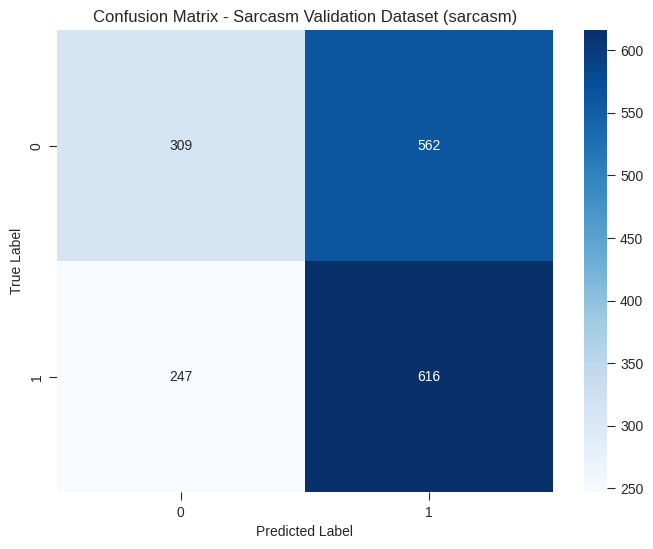

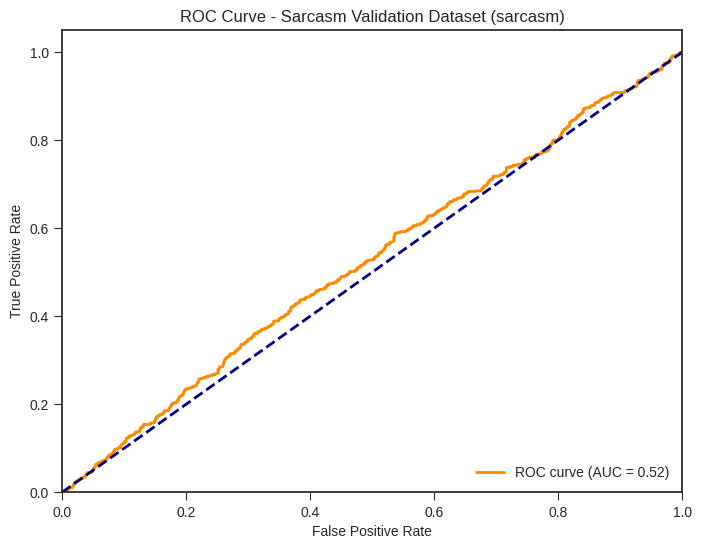

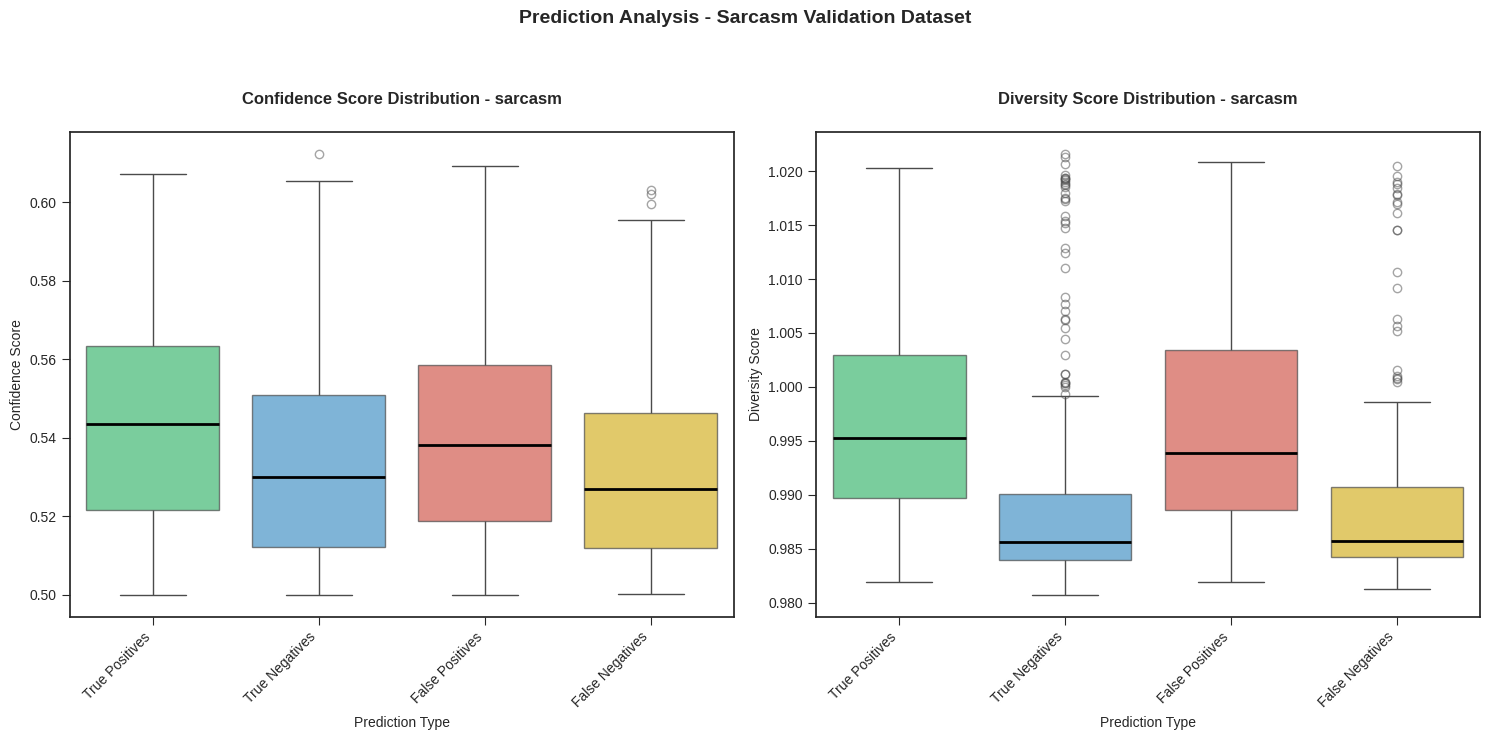


Evaluation Results for Sarcasm Validation Dataset dataset (sarcasm):
--------------------------------------------------
loss: 0.6895
accuracy: 0.5334
f1: 0.5180
diversity_gap: 0.0036
precision: 0.5394
recall: 0.5334
              precision    recall  f1-score   support

     Class 0       0.56      0.35      0.43       871
     Class 1       0.52      0.71      0.60       863

    accuracy                           0.53      1734
   macro avg       0.54      0.53      0.52      1734
weighted avg       0.54      0.53      0.52      1734



In [ ]:
val_pred, metrics, diversity_scores = evaluate_and_visualize(
    model,
    sarcasm_val_loader,
    criterion,
    task="sarcasm",  # or "sarcasm"
    save_path="evaluation_results/",
    dataset_name="Sarcasm Validation Dataset"
)